In [1]:
# This line upgrades and makes sure required packages are installed.
# It it fails just rerun this cell!
#!pip install fastai==2.2.7  && pip install -Uqq torchsummary
#!pip install --force-reinstall fastai==2.5.3 && pip install -Uqq torchsummary && pip install --force-reinstall fastcore==1.3.27 && pip install --force-reinstall torch==1.8.1



$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\uv}{\mathbf{u}}
 \newcommand{\vv}{\mathbf{v}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\Um}{\mathbf{U}}
 \newcommand{\Vm}{\mathbf{V}} 
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
 \newcommand{\Lambdav}{\boldsymbol\Lambda}
$

# Deep Learning and Neural Networks


### ITCS 5156
### Minwoo "Jake" Lee and Ben Poole

<br/>
<font color="blue"><b>

NAME: Jacob Miller 801132329

</b> </font>

## Goal
The goal of this week's lab is to introduce you to deep learning and neural networks along with related concepts such as gradient descent and back-propagation. Additionally, we will be taking a look at the PyTorch and FastAI libraries for creating and quickly training neural networks.

As mentioned before there is A LOT of ground to cover so this weeks lab is going to be a little longer and more detailed.

## Agenda

- Getting Started: PyTorch and Gradient Descent
    - Gradient Descent With a Single Point
    - Creating a Linear Neural Network and Training With Gradient Descent
- Building and Training a Deep Neural Network
    - Data Loading and Pre-processing With FastAI
    -  Building and Training a Neural Network

## Packages Required
- [PyTorch](https://pytorch.org/get-started/locally/) 
- [FastAI](https://docs.fast.ai/) 
- [PyTorch Summary](https://pypi.org/project/torch-summary/)

## TODO Links
Note this does not work in colabs! Instead, use the table of contents to find TODOs when using a colab!

1. [TODO1 (3 points)](#TODO1) 
2. [TODO2 (5 points)](#TODO2) 
3. [TODO3 (5 points)](#TODO3) 
4. [TODO4 (5 points)](#TODO4)  
5. [TODO5 (5 points)](#TODO5) 
6. [TODO6 (15 points)](#TODO6) 
7. [TODO7 (15 points)](#TODO7) 
8. [TODO8 (15 points)](#TODO8) 
9. [TODO9 (15 points)](#TODO9) 
10. [TODO10 (15 points)](#TODO10)
11. [Feedback (2 points)](#feedback)


## Imports

If the below assert is failing it is because you dont have the correct FastAI version. If you are in Google Colab and you already ran the install line at the top of the notebook, try restarting your runtime or kernel adn then running these imports again.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch 

# Set PyTorch to use CPU ONLY 
# device = torch.device("cpu")
# torch.cuda.is_available = lambda : False

# Select which device PyTorch should use. If you have a gpu but
# want to use a the cpu only comment out this line and use the above
# lines instead.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import fastai
assert fastai.__version__ >= '2.2.7'
# Set FastAI to use CPU ONLY as well
# If use_cuda == None then GPU is used
# If use_cuda == True Error is thrown
# If use_cude == False CPU is used
# torch_core.defaults.use_cuda = False

# Getting Started: PyTorch and Gradient Descent

 To start off the lab, let's look at how we can use PyTorch to automatically compute the gradients for us. First of all, what is PyTorch exactly? To put it bluntly, PyTorch describes itself as the following:  

> PyTorch is an optimized tensor library for deep learning using GPUs and CPUs.

However, in order for PyTorch to be a deep learning library, it not only needs a programming framework for creating neural network models, losses, and metrics but it also needs what we call an [automatic differentiation engine](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). 

At a high-level an "automatic differentiation engine" is just a way to automatically compute the gradients of a function (like neural networks). This means that PyTorch can  perform the gradient descent for us and thus can also perform back-propagation for us in order to update our model's weights! 

## Gradient Descent With a Single Point

Let's start off simple and review the concept of gradient descent by looking at a toy problem.

Below we can see a toy example of gradient descent in action. Given some x-y coordinate starting point on a function, in particular the $x^2$ function, we want to find the minimum. To do so, we can simply use the idea of gradient descent to slowly move from our starting x-y position to the minimum of the $x^2$ function. Since the $x^2$ function is essentially just a bowl the minimum will be at 0. 

Remember from calculus class that we could directly solve for the minimum by taking the derivative of our function and setting it equal to $f'(x) = 0$ and then solve for $x$! For more complex functions (like neural networks) computing the minimum by hand just is not possible. This is why we need gradient descent in order to approximate the minimum instead!

Further we define a helper plotting function called `plot_function()` which will plot any passed mathematical function. Additionally, we also define our $x^2$ function `f()` that we will be using in our gradient descent toy problem.

In [3]:
def plot_function(f, steps=100, tx=None, ty=None, title=None, min_ls=-2, max_ls=2, ax=None, figsize=(6,4)):
    x = torch.linspace(min_ls, max_ls,steps)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: 
        ax.set_xlabel(tx)
    if ty is not None: 
        ax.set_ylabel(ty)
    if title is not None: 
        ax.set_title(title)

def f(x): 
    return x**2

Let's use our `plot_function()` function to plot our $x^2$ function `f()`. Next, we can plot the starting point of our gradient descent problem using `x_start` and `y_start`. **The starting point will always be represented by the green dot!**


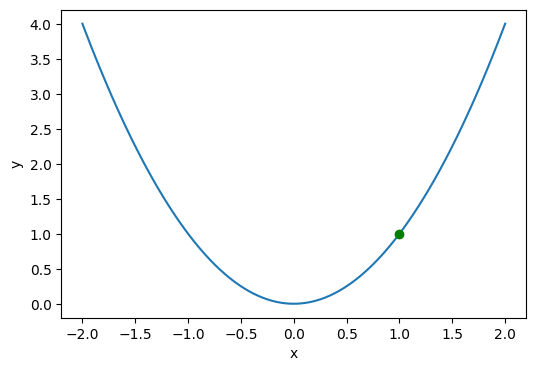

In [4]:
plot_function(f, tx='x', ty='y')

x_start = 1 
y_start = f(1)
plt.plot(x_start, y_start, 'go')

Alright, we have our function and our starting point plotted! Now we just need to define our gradient descent algorithm. We do so by defining a `gradient_descent()` function with computes the gradient by using PyTorchs automatic differentiation engine!

There is a lot going on in this code. A deep explanation of all parts of this code is out of scope for this lab but let's cover the basics as we'll be simplifying and abstracting away many aspects of this code as the lab goes on. We have left some comments in the code for those that are curious about what is happening, but a high-level understanding will suffice for now.

All the below code is doing is performing gradient descent for some number of pre-defined steps or epochs defined by `n_iter`. This means that given our start position `start_x`,  a function `f`, and a learning rate `lr`, gradient descent will try to find the minimum of the function given, starting from the passed start position, by taking small steps. Remember the size of a step is determined by the learning rate `lr`.


The important aspects of the code are:
> `yt.backward()` 
> - This line computes the derivative or gradient of our $x^2$ function.

> `xt.data = xt - (lr * xt.grad)`
> - Equation for taking a gradient step. This equations moves our x-coordinate closer to the minimum by using the computed gradient `xt.grad`. We apply the learning rate `lr` to scale the gradient down in order to take small steps and not overshoot the minimum!  
> - Note the gradient descent step formula is defined as $x = x - \alpha \nabla f(x)$ where $\nabla f(x)$ is the gradient of the selected function, $\alpha$ is the learning rate and $x$ is the x-coordinate.

In [5]:
def gradient_descent(x, f, n_iter=10, lr=.1):

    # Put x in a tensor
    # The requires_grad parameter means we will take the
    # gradient with respect to x. Thus any computations
    # preformed on x will be tracked!
    xt = torch.tensor(float(x), requires_grad=True)
    
    # Calculate the y coordiante and put it in a tensor.
    # Since xt used the requires_grad parameter and is used to 
    # compute yt PyTorch has tracked the function f() and 
    # will know to take the gradient with respect to function f().
    yt = f(xt)
    y = yt.detach().item()

    x_hist = [x]
    y_hist = [y]

    for i in range(n_iter):
        # PyTorch method for computing the derivative of a tensor. 
        # Since our tensor yt is calculated by a function, PyTorch tracked this 
        # calculation and knows how to differeitiate it!
        # This is the same as loss.backward() in PyTorch!
        yt.backward() 

        print("(x, y): ({:.3f}, {:.3f}), Grad: {:.4f}, Scaled-grad: {:.4f}".format(
             xt.item(), yt.item(), xt.grad.item(), xt.grad.item()*lr)
             )

        # Take a gradient descent step.
        # Store new xt in xt.data so PyTorch
        # does not track this operation as an 
        # operation that needs to be differentiated
        # This is the same as optim.step() in PyTorch!
        xt.data = xt - (lr * xt.grad)
        # Figureout what our y-coordiante is after
        # taking the gradient step
        yt = f(xt)

        # Get the x and y positions from tensors
        x = xt.detach().item()
        y = yt.detach().item()

        # x and y position history
        x_hist.append(x)
        y_hist.append(y)

        # Convergence check to see if gradient is near zero!
        # In other words, check if gradient is near a minimum!
        # Recall that when the gradient equals zero we are either
        # near a local minimum, local maximum, or saddle point!
        if abs(xt.grad.item()) <= .001:
            break
        # Reset gradients to zero otherwise PyTorch will
        # sum the gradients if xt.grad != 0!
        xt.grad.zero_()
        
    print("Total iterations taken: {}".format(i))
    return x_hist, y_hist

Let's see what this code really does! Below we specify a learning rate `lr`, the number of gradient steps to take `n_iter`, and the x-coordinate start position `start_x`.

In [6]:
# Learning rate
lr = .1
# Max number of gradient descent steps to take 
n_iter = 10
# Starting x coordinates (corresponding y is calcuated inside gradient descent)
start_x = 1

x_hist, y_hist = gradient_descent(start_x, f, n_iter, lr)

(x, y): (1.000, 1.000), Grad: 2.0000, Scaled-grad: 0.2000
(x, y): (0.800, 0.640), Grad: 1.6000, Scaled-grad: 0.1600
(x, y): (0.640, 0.410), Grad: 1.2800, Scaled-grad: 0.1280
(x, y): (0.512, 0.262), Grad: 1.0240, Scaled-grad: 0.1024
(x, y): (0.410, 0.168), Grad: 0.8192, Scaled-grad: 0.0819
(x, y): (0.328, 0.107), Grad: 0.6554, Scaled-grad: 0.0655
(x, y): (0.262, 0.069), Grad: 0.5243, Scaled-grad: 0.0524
(x, y): (0.210, 0.044), Grad: 0.4194, Scaled-grad: 0.0419
(x, y): (0.168, 0.028), Grad: 0.3355, Scaled-grad: 0.0336
(x, y): (0.134, 0.018), Grad: 0.2684, Scaled-grad: 0.0268
Total iterations taken: 9


As we can see below, we managed to use gradient descent to slowly move from our initial position, designated by the green dot, all the way down very close to the minimum. Each red dot indicates where we are after taking a gradient step and the blue dot indicates our final position.

Likewise if we look at the output of the `gradient_descent()` function above we can see the exact (x, y) position before taking a gradient step and after (these positions are also stored inside `x_hist` and `y_hist`). Further, we can see the gradient that was computed and the gradient scaled by the learning rate or the gradient step actually taken. 

Notice, at first we take very large steps as the gradient is large but as we approach the minimum, it slows down and the steps get smaller and smaller!

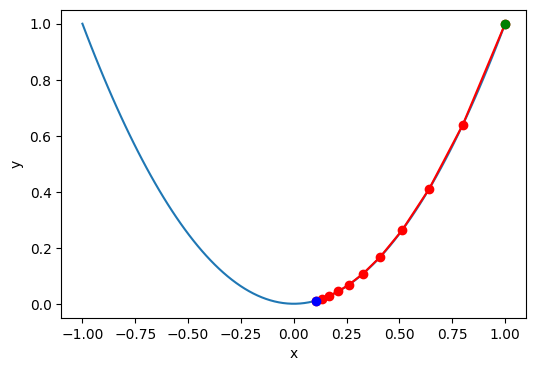

In [7]:
# Plot the our function
plot_function(f, min_ls=-round(max(x_hist)), max_ls=round(max(x_hist)), tx='x', ty='y')

plt.plot(x_hist, y_hist, 'ro-')

# Plots start and ending positions
plt.plot(x_hist[0], y_hist[0], 'go')
plt.plot(x_hist[-1], y_hist[-1], 'bo');

You might be wondering, well, if we take smaller and smaller steps near the minimum why don't we just increase the learning rate so then we can take larger steps near the minimum.

<div id="TODO1"></div>

#### TODO 1

Well, what does happen if we try increasing the learning rate? Let's warm-up by trying this now!

1. Define the learning rate as .9 and store the output into `lr`.
2. Call the `gradient_descent()` like we did above and pass to it the `x_start`, the $x^2$ function `f`, the number of gradient descent steps to take `n_iter`, and the learning rate `lr`.Store the output into `x_hist` and `y_hist`
3. Plot the history of the x-y coordinates by plotting `x_hist` and `y_hist` using the format `ro-`.

(x, y): (1.000, 1.000), Grad: 2.0000, Scaled-grad: 1.8000
(x, y): (-0.800, 0.640), Grad: -1.6000, Scaled-grad: -1.4400
(x, y): (0.640, 0.410), Grad: 1.2800, Scaled-grad: 1.1520
(x, y): (-0.512, 0.262), Grad: -1.0240, Scaled-grad: -0.9216
(x, y): (0.410, 0.168), Grad: 0.8192, Scaled-grad: 0.7373
(x, y): (-0.328, 0.107), Grad: -0.6554, Scaled-grad: -0.5898
(x, y): (0.262, 0.069), Grad: 0.5243, Scaled-grad: 0.4719
(x, y): (-0.210, 0.044), Grad: -0.4194, Scaled-grad: -0.3775
(x, y): (0.168, 0.028), Grad: 0.3355, Scaled-grad: 0.3020
(x, y): (-0.134, 0.018), Grad: -0.2684, Scaled-grad: -0.2416
(x, y): (0.107, 0.012), Grad: 0.2147, Scaled-grad: 0.1933
(x, y): (-0.086, 0.007), Grad: -0.1718, Scaled-grad: -0.1546
(x, y): (0.069, 0.005), Grad: 0.1374, Scaled-grad: 0.1237
(x, y): (-0.055, 0.003), Grad: -0.1100, Scaled-grad: -0.0990
(x, y): (0.044, 0.002), Grad: 0.0880, Scaled-grad: 0.0792
(x, y): (-0.035, 0.001), Grad: -0.0704, Scaled-grad: -0.0633
(x, y): (0.028, 0.001), Grad: 0.0563, Scaled-gra

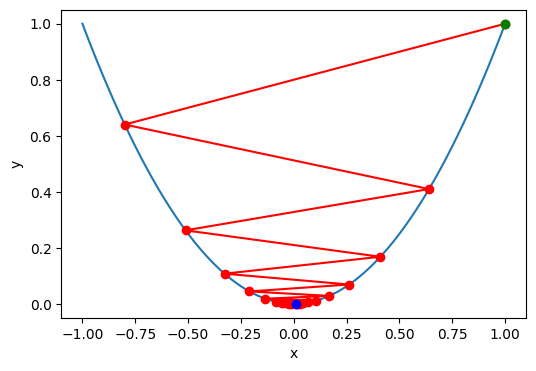

In [8]:
# TODO 1
lr = .9

# Max number of gradient descent steps to take 
n_iter = 20
# Starting x, y coordinates
x_start = 1

# TODO 2
x_hist, y_hist = gradient_descent(start_x, f, n_iter, lr)

# Plot the our function
plot_function(f, min_ls=-round(max(x_hist)), max_ls=round(max(x_hist)), tx='x', ty='y')

# TODO 3
plt.plot(x_hist, y_hist, 'ro-')

# Plots start and ending positions
plt.plot(x_hist[0], y_hist[0], 'go');
plt.plot(x_hist[-1], y_hist[-1], 'bo');

Well, it turns out we will still find our way to a minimum but our path there is quite a bit more chaotic. If we increase the learning rate any further gradient descent might just become even more unstable and either not find the minimum or completely overshoot it!

If you want, try setting the learning rate equal to 1 and see how the gradient descent algorithm just bounces back and forth!

### How does this idea of finding the minimum translate to machine learning?

So how does this simple gradient descent on a given point on the function $x^2$ relate to back-propagation? 

Well, essentially the same idea still applies, however now our function will be some more complex model with say 60 million weights which we need to tune. Further, we cant just perform gradient descent on our weights we need a **loss function** to act as a proxy for telling us when we might have the optimal weights. In other words, we need a loss function to assess how well our weights are doing at solving the problem at hand! By taking the gradient with respect to the loss function, which our weights are now a part of, we can start moving our loss and our weights towards some minimum! 

If we use a loss function like mean squared error we can then roughly recreate our gradient descent on a single point example given above where we can think about the error as the x-axis and the error squared as the y-axis! Meaning, when we randomly initialize our weights we will have some starting x-position (in other words some initial error) and some corresponding y-position (in other words some initial squared error). 

Additionally, we can think about the error as a proxy to good weights, the lower the error the better our weights are at solving our problem! See the below image for example of this idea!

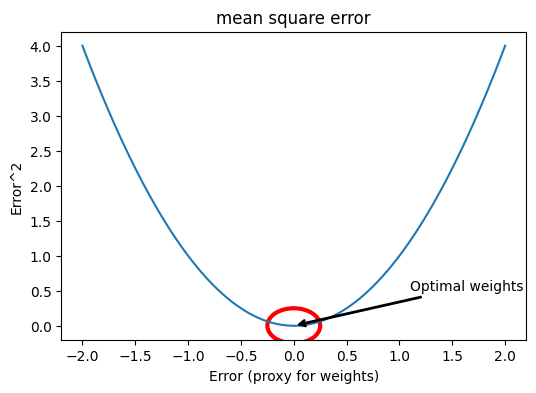

In [9]:
plot_function(f, tx='Error (proxy for weights)', ty='Error^2', title='mean square error')

c = plt.Circle((0, 0), radius=.25, fill=False, lw=3, color='red', )
plt.annotate('Optimal weights', xy=(0,0),
              xytext=(1.1, .5),
              arrowprops=dict( arrowstyle="->", lw=2))
plt.gca().add_artist(c)


## Creating a Linear Neural Network and Training With Gradient Descent

Let's ease into this idea of creating deep neural networks by first creating a linear neural network in PyTorch and using gradient descent to learn the weights! Below is an example of a single layer linear neural network. Notice that we currently have no hidden layers!

<center>
<img src="https://live.staticflickr.com/65535/51084457991_ca0f478b25_b.jpg" width="300" height="300" alt="affine_networks_veq">
</center>

We'll begin by creating some very simple regression data just to show how gradient descent works for such a simple neural network. Remember a linear neural network is the same as linear regression!

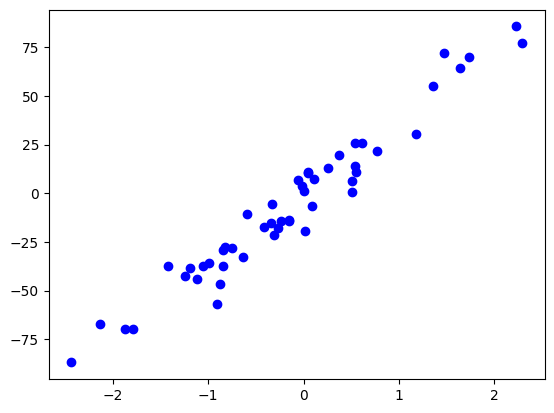

In [10]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

X, targets = make_regression(n_samples=50, n_features=1, noise=8, n_informative=1, random_state=2)
plt.plot(X[:, 0], targets, 'bo')

Given this simple data let's create a neural network in PyTorch! In order to do so we need to define 3 crucial components that we always need when working with neural networks in PyTroch and really in general. 

**3 Crucial Components**
1. First, we need to define our PyTorch neural network **model**.
2. Second, we need to define the type of **optimizer** we want to use to update our model's weights/parameters.
3. Third, we need to define the type of **loss** we want to use to asses our model's performance and compute the gradients based off of.

### (1) Defining a Sequential PyTorch Model

Below, we define a very simple PyTorch neural network model using the `Sequential` class ([docs](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)) which adds new layers in the order in which they are passed. Notice, we are only passing a the `nn.Linear` class ([docs](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) which is a linear layer or also called a Dense or feedforward layer. This linear layer will be our first layer in the neural network. The linear layer only applies the basic linear transformation or affine function to the inputs, think of $y = w^Tx + b$ where $x$ is the input into the layer, $w$ are the weights, and $b$ is the bias.

As we can see the `nn.Linear(in_features=X.shape[-1], out_features=1)` requires two inputs: the number of input features and the number of output features. Since this is the first layer hidden layer in our neural network our input features are equal to the number of features in our data. In this case we set `in_features=X.shape[-1]`. The rule of thumb here is that the `in_features` needs to be equal to the previous layer's output! Our output features represent the number of neurons in our layer. Since we are making a linear neural network we only need a single neuron so we set `out_features=1`.

Further, it is good practice to move our model to the our GPU if we have one. This is why we call `.to(device)`. Remember that `device` was set at the start of the notebook and can take on one of two values: 'GPU' or 'CPU'. The value selected depends on whether you have a GPU or not. If a 'GPU' is not detected then `.to(device)` will keep the model on the 'CPU' since `device` will be equal to 'CPU'. 

In [11]:
import torch.nn as nn
# Define a linear neural network
model = nn.Sequential(
    nn.Linear(in_features=X.shape[-1], out_features=1)
).to(device)

By calling the `state_dict()` method ([docs](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) we can see all the parameters of the model for each layer.

In [12]:
model.state_dict()

OrderedDict([('0.weight', tensor([[-0.2470]], device='cuda:0')),
             ('0.bias', tensor([0.1261], device='cuda:0'))])

We can further visualize what our model will look like by using the `summary` function from the `torchsummary` library. Notice we have to pass the expected shape of our data or in other words the number of features we expect to pass to the model.

In [13]:
from torchsummary import summary
expected_input_shape = (X.shape[-1],)
summary(model, expected_input_shape);

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               2
Total params: 2
Trainable params: 2
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


As we can see our total trainable parameters are 2 which makes sense for our linear model as our output layer has `out_features=1` which means we have 1 weight and 1 bias for the output unit. This means we have 2 parameters!

Note that the -1 in the output shape refers to our unknown mini-batch size since all the summary cares about is the number of features!

### (2) Defining an Optimizer

Next, we need to define our PyTorch optimizer. The optimize let's us select the type of optimization method used to learn our weights! In our case, we just want to use normal gradient descent which is defined by `torch.optim.SGD` class in PyTorch ([docs](https://pytorch.org/docs/stable/optim.html)).

As you'll see in the documentation, there are many types of gradient descent. We'll use a popular variant of gradient descent later on, but for now we can use `SGD` or stochastic gradient descent. 

The optimizer requires that we pass in our model's parameters so that it knows which parameters to be optimizing. Optionally, we can pass a learning rate as well.

Note that the stochastic gradient descent and vanilla gradient descent refer roughly to the same thing but stochastic gradient descent just indicates we randomly sample our data in mini-batches instead of feeding all the data to the model at once, we'll touch more on this later. For right, just know they are essentially the same thing.

In [14]:
# Define SGD optimizer
optim = torch.optim.SGD(model.parameters(), lr=.1)

### (3) Defining a Loss Function

Lastly, before we can learn the weights for our linear neural network we need to define a loss or cost function. Recall that a loss function defines how well our model is doing. By minimizing the loss and taking the gradient with respect to our loss we can adjust our weights in the pursuit of finding a local or global minimum!

Let's use the mean square error (MSE) loss. We have two options for defining MSE: we can manually define it in a function or we can use PyTorch's predefined MSE loss class ([docs](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)). For now, we'll just use PyTorch's as we can count on it working as intended!

Note that just like the optimizers PyTorch defines many different types of losses that we can use ([docs](https://pytorch.org/docs/stable/nn.html#loss-functions))!

In [15]:
# Define loss function manually
def mse(preds, targets):
    """Mean squared error loss function"""
    return ((preds-targets)**2).mean()

# Or we can use PyTorch's predefined MSE loss
# Note that the `reduction='mean' means we want to take the average 
# loss from all the samples that were passed to the loss at once.
# This is the same as using .mean() in the above manually defined mse function.
# By default PyTorch nn.MSELoss sets reduction=mean so specifying it again is redundant!
loss_func = nn.MSELoss(reduction='mean')

### Putting it Altogether!
Okay, we have finally built the key requirements for training a neural network: a model, a optimizer, and a loss! Now we can use the loss function in conjunction with the optimizer to learn the weights of our linear neural network! In doing so we can learn a line of best fit for our synthetic regression data.

Take some time to go through the comments and the below break down of the `gradient_descent()` function code and see if you understand what is happening. If you have any questions about any aspect of the code be sure to post on CampusWire!

>  `X = torch.tensor(X).float().to(device)`
> - Cast X as PyTorch tensor.
> - Cast the tensor as float32 using `.float()`. We do this to reduce memory usage (float32 takes up less memory) and to prevent type mismatch errors later on.

    
>  `targets = torch.tensor(targets).float().view(-1,1).to(device)`
>  - Cast targets as PyTorch tensor.
>  - Change the tensor to a float32 using `.float()`. 
>  - Reshape the tensor from to using `.view()` to have the shape `(len(targets), 1)` instead of `(len(targets),)`. The `.view()` method is PyTorch's version of NumPy's `.reshape()` method


> `optim.zero_grad()`
> - Reset any calculated gradients to zero. Every time we compute gradients, PyTorch will store them. If we don't clear the previous gradients, when we compute new gradients, they will be added to the existing gradients (WE DO NOT TYPICALLY WANT THIS)!


> `loss.backward()`
> -  PyTorch's method for computing the gradients of a tensor. Since our loss is in a tensor we have access to the `.backward()` method which will compute the gradients with respect to our loss tensor!
> - See the following [forum post](https://discuss.pytorch.org/t/how-are-optimizer-step-and-loss-backward-related/7350) on how optimization works in PyTorch.


> `optim.step()`
> - PyTorch's method for taking a gradient descent step which will update our model's parameters
> - This line is essentially the same as the following line from our previous gradient descent code: `xt.data = xt - (lr * xt.grad)`. However, now PyTorch does all the calculations for us.
> - See the following [stack overflow](https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step) post for how `optim.step()` and `loss.backward()` interact

> `.detach()`
> - This method allows us to indicate to PyTorch that we don't want the automatic differentiation engine to track the changes to these tensors. Many times PyTorch will throw a warning telling you that you need to use the `.detach()` method on certain tensors
> - More information can be found on this [blog](http://www.bnikolic.co.uk/blog/pytorch-detach.html) post on `.detach()`

> `.to(device)`
> - This method moves the PyTorch tensors and models to the specified device, either the CPU or GPU. A tensor on the CPU can not be used in a computation with a tensor on the GPU. This means we have to manage which device the tenors are on.

In [16]:
def gradient_descent(X, targets, model, optim, loss_fn, epochs=50):   
    # Cast X as tensor
    X = torch.tensor(X).float().to(device)

    # Cast targets as tensor
    targets = torch.tensor(targets).float().view(-1,1).to(device)
    errors = []

    for e in range(epochs):
        # Reset gradients to zero otherwise PyTorch will
        # sum the gradients if weights.grad != 0!
        optim.zero_grad()
        
        # Run data through linear model and get preds
        preds = model(X)
        
        # Compute error and loss based on preds
        loss = loss_fn(preds, targets)
        error = preds-targets
        errors.append(error.cpu().detach().numpy())
        
        # PyTorch method for computing the derivative of a tensor.
        loss.backward()
        
        # Extract out gradients that PyTorch automatically computed
        # when we called loss.backward()
        grads = [param.grad.view(-1) for param in model.parameters()]
        print("Loss: {:.5f}, Weight Grad {:.5f}, Bias Grad: {:.5f}".format(loss, 
                                                          grads[0].detach().item(),
                                                          grads[1].detach().item()))

        # PyTorch method for taking a gradient descent step
        # which updates our model's parameters
        optim.step()

    return errors

Well that's it! We can write the entire gradient descent algorithm for updating weights  in just a few lines using PyTorch's auto differentiation engine!

Finally let's pass our data `X`, targets `targets`, model `model`, optimizer `optim`, and loss function `mse` to the gradient descent algorithm and see if we can find a line of best fit for our data!

In [17]:
errors = gradient_descent(X, targets, model, optim, loss_func, epochs=25)
# Extract the weights we learned from our PyTorch model
weights = np.array([param.detach().item() for param in model.parameters()])
# Turn all our errors over all the epochs in an NumPy array
errors = np.hstack(errors)
loss = (errors**2).mean(axis=0)

Loss: 1588.02625, Weight Grad -81.58399, Bias Grad: 12.73367
Loss: 984.12390, Weight Grad -63.23874, Bias Grad: 7.90677
Loss: 624.07184, Weight Grad -49.07355, Bias Grad: 4.55796
Loss: 408.55658, Weight Grad -38.12539, Bias Grad: 2.27483
Loss: 279.00412, Weight Grad -29.65512, Bias Grad: 0.75430
Loss: 200.76857, Weight Grad -23.09505, Bias Grad: -0.22538
Loss: 153.29187, Weight Grad -18.00887, Bias Grad: -0.82579
Loss: 124.33264, Weight Grad -14.06097, Bias Grad: -1.16395
Loss: 106.57365, Weight Grad -10.99305, Bias Grad: -1.32415
Loss: 95.62280, Weight Grad -8.60608, Bias Grad: -1.36656
Loss: 88.83197, Weight Grad -6.74662, Bias Grad: -1.33378
Loss: 84.59686, Weight Grad -5.29626, Bias Grad: -1.25558
Loss: 81.94061, Weight Grad -4.16352, Bias Grad: -1.15249
Loss: 80.26527, Weight Grad -3.27767, Bias Grad: -1.03836
Loss: 79.20286, Weight Grad -2.58396, Bias Grad: -0.92229
Loss: 78.52557, Weight Grad -2.03998, Bias Grad: -0.81005
Loss: 78.09162, Weight Grad -1.61280, Bias Grad: -0.70506

Well, that's a descent amount of output. What's happening here? First, notice that our loss starts out really large and then seems to converge to a value. We can visualize the loss for each epoch to see this as well using the below plot. Similarly, notice how the loss is tied to our gradients. 

Notice, as the the gradients get smaller the loss changes less. The gradient for our weight is defined by "Weight Grad" and the gradient for our bias is defined by "Bias Grad." 

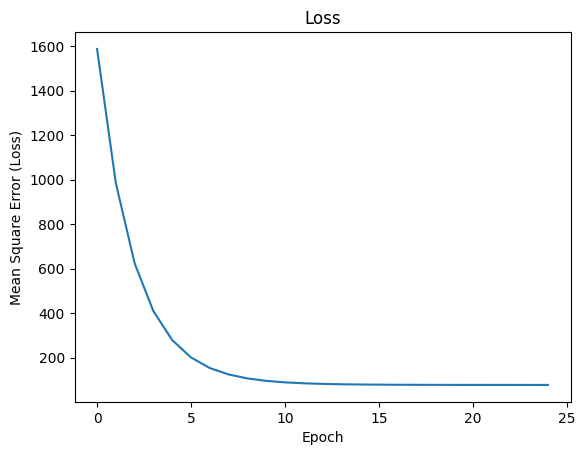

In [18]:
plt.title("Loss")
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error (Loss)');

The below graph shows off how well our predictions are doing. The blue dots represent our targets, the green dots represent our predictions, and the red line represents the line of best fit!

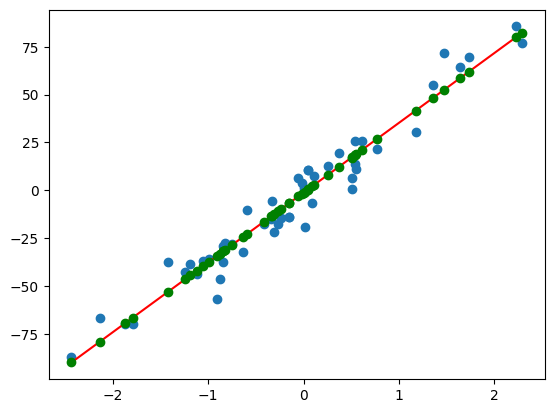

In [19]:
tt = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 10)
line_of_bf = weights[1]+weights[0]*tt
preds = model(torch.tensor(X).float().to(device)).cpu().detach().numpy()

plt.plot(X[:, 0], targets, 'o')
plt.plot(tt, line_of_bf, 'r-')
plt.plot(X[:, 0], preds, 'go')

We can further visualize how predictions do when plotted directly with our targets.

Note that both plots are showing the same thing but from a different perspective!

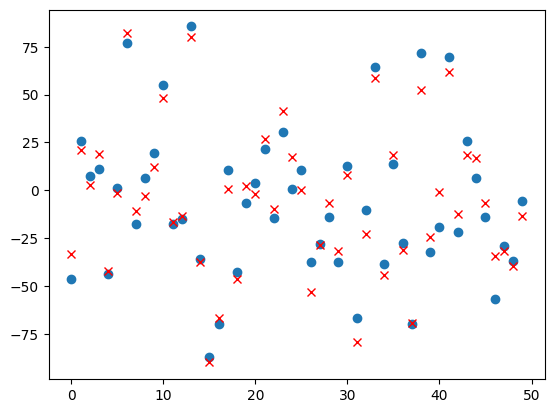

In [20]:
plt.plot(targets, 'o')
plt.plot(preds, 'rx')

Now, let's relate our simple gradient descent with a linear neural network back to our example of using gradient descent for a single point. 

To do so, we can look at each data sample as being a separate optimization problem, similar to what we did before where we had a given point on the $x^2$ function and we wanted to slowly move our point towards the minimum. However, now we have weights which parameterize our "starting point" and we also have to use gradient feedback from all our samples in order to find weights that roughly satisfy all our data samples, in other words find weights that generalize! 

The below visualization shows us each individual sample's error (x-axis) and squared error (y-axis). This plot allows us to see how our weights are doing at finding the "minimum" error for each sample.). Each data sample starts at an initial error (marked in green) and ends up at a final error (marked in blue) due to this group optimization  some samples end up with a lower error while others regress to a worse error than they started with!

Recall that we take the **mean** of our loss to get the general idea of how well each sample optimization problem is doing. Given this, it does make sense that each individual error can't be minimized as gradient descent needs to take into account **all samples that were computed in the loss**!

Note, when we take the mean of our loss under the hood PyTorch is efficiently computing all the gradients for each sample passed to the loss. This means PyTorch is using the average gradient of all the samples passed to the loss to update the weights!

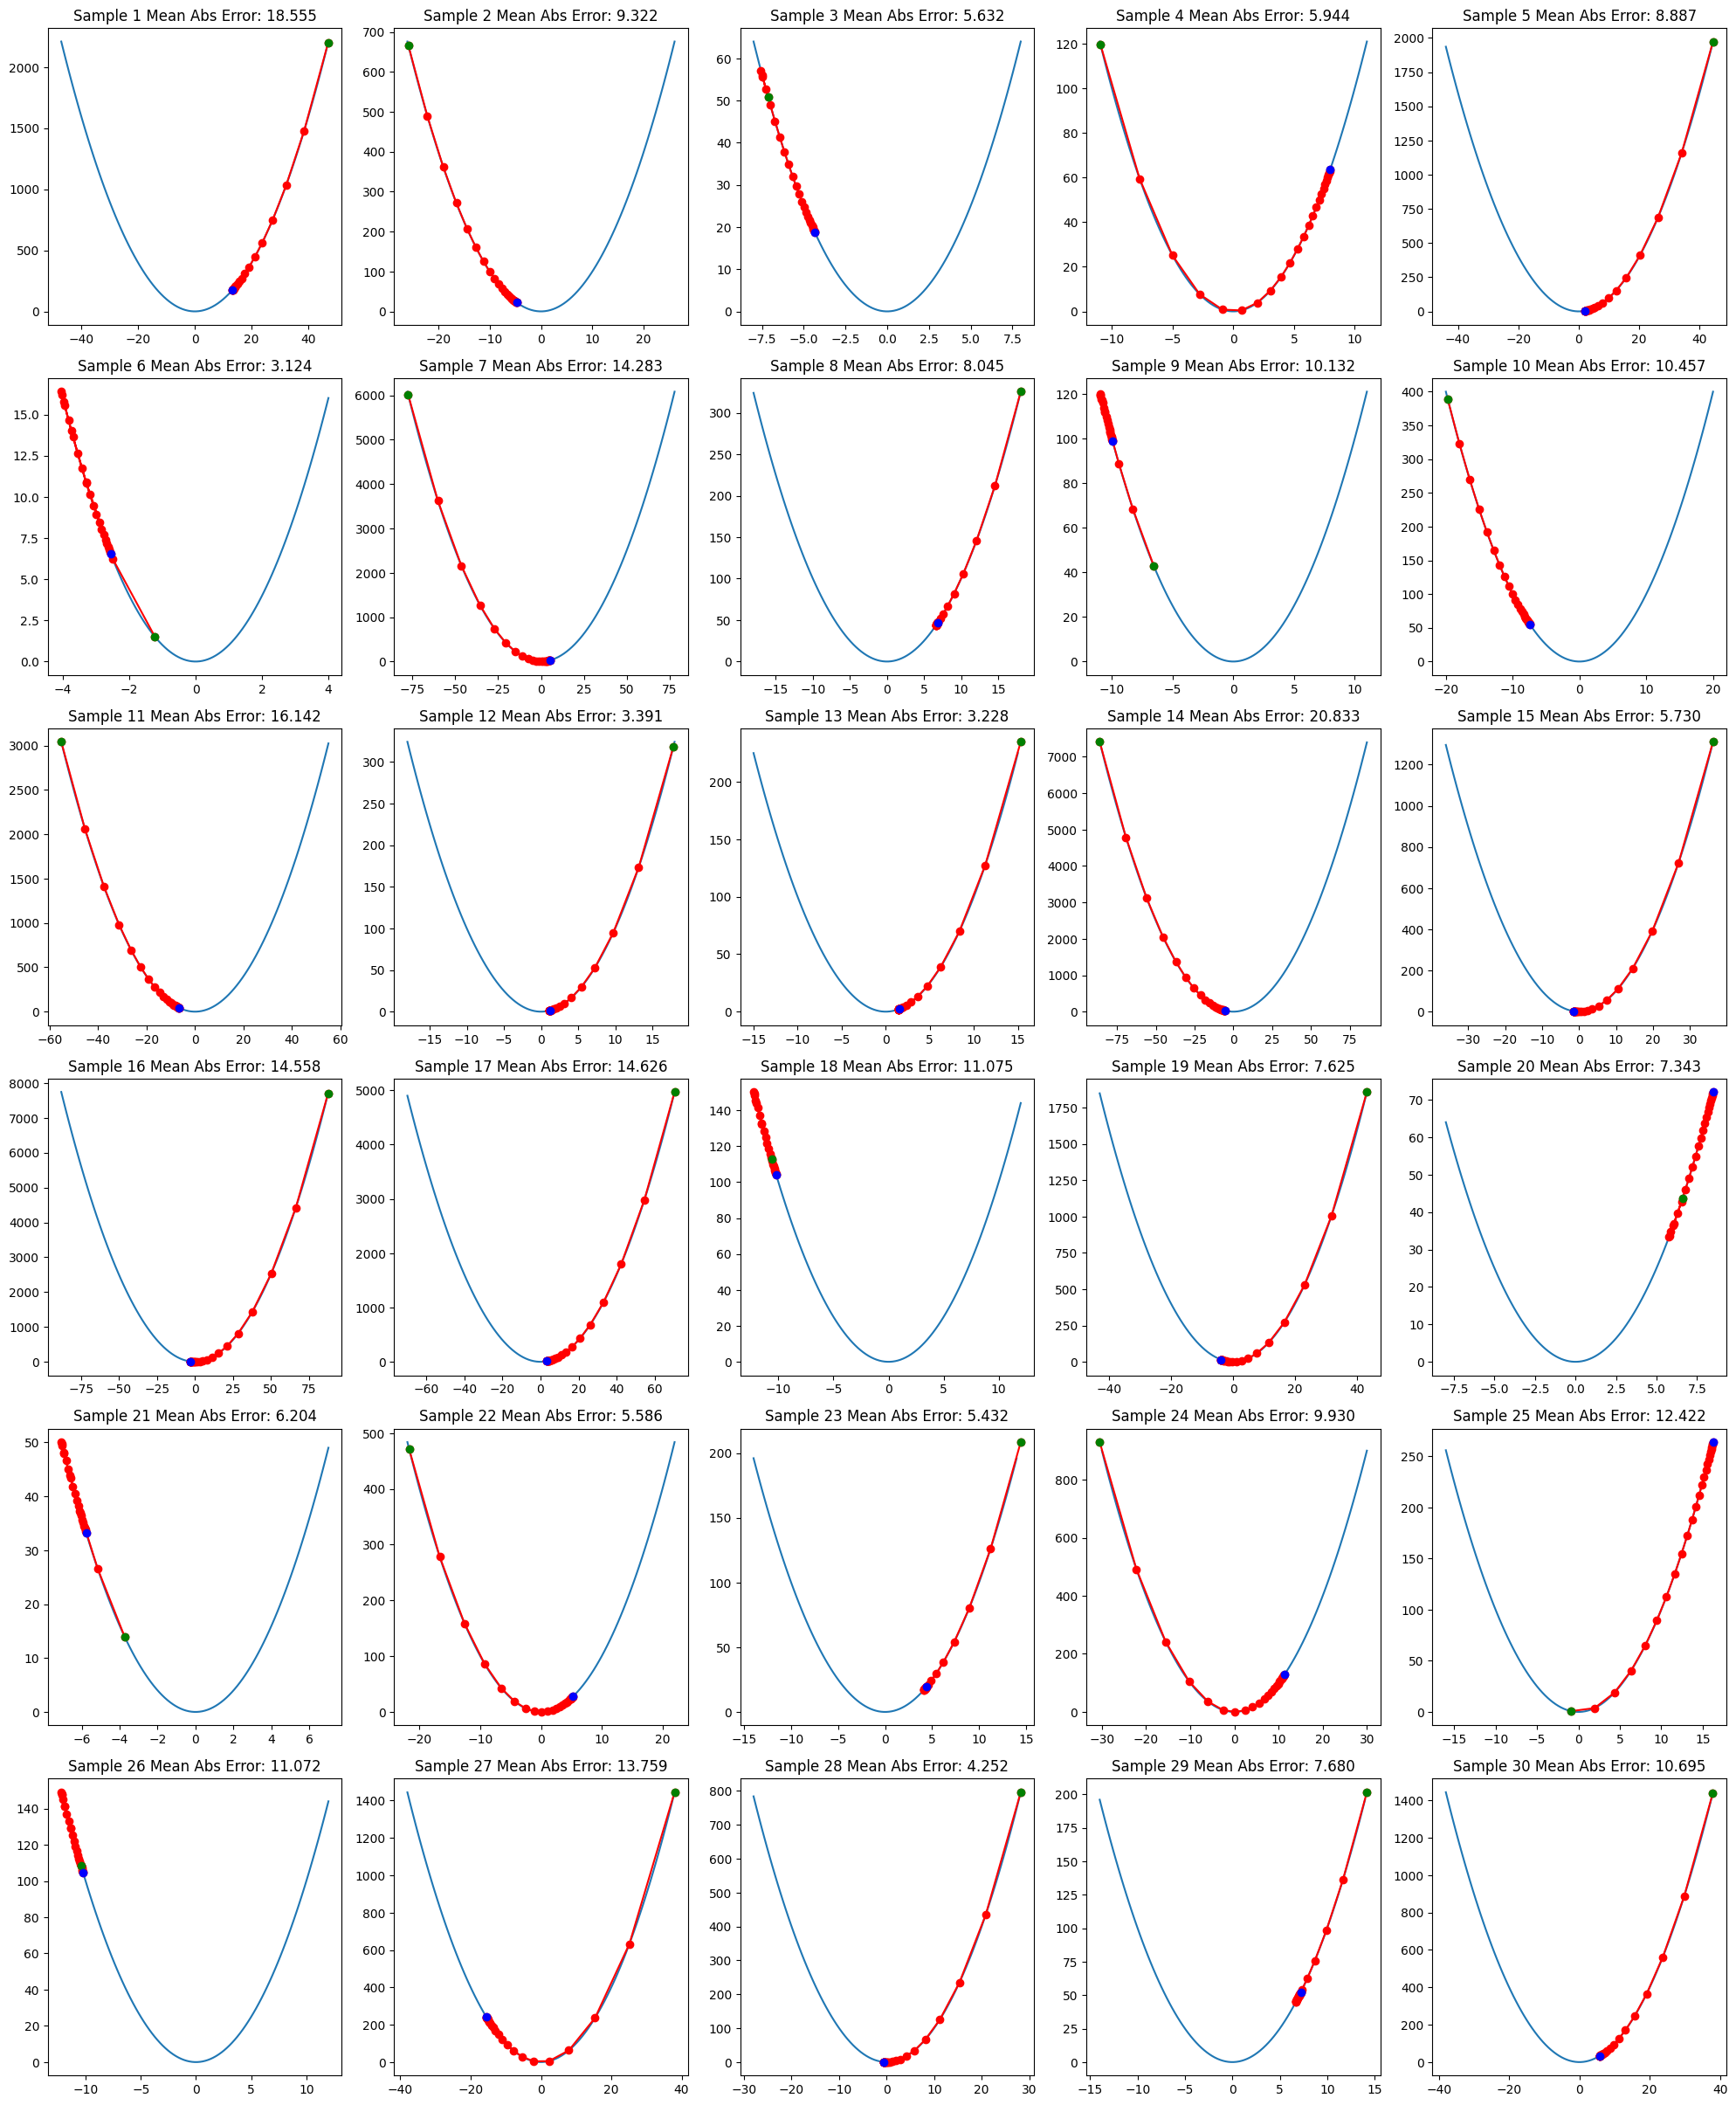

In [21]:
from matplotlib import gridspec

samples = 30
cols = 5
rows = int(np.ceil(len(X) / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(20,40))
for i in range(samples):
    ax = fig.add_subplot(gs[i])
    smp_errors = errors[i]
    plot_function(f, 
                  min_ls=np.round(np.max(abs(smp_errors))), 
                  max_ls=-np.round(np.max(abs(smp_errors))), 
                  ax=ax)
    ax.plot(smp_errors, smp_errors**2, 'ro-')
    ax.plot(smp_errors[0], smp_errors[0]**2, 'go')
    ax.plot(smp_errors[-1], smp_errors[-1]**2, 'bo')
    ax.set_title("Sample {} Mean Abs Error: {:.3f}".format(i+1, np.abs(smp_errors).mean()))

fig.tight_layout()

<div id="TODO2"></div>

#### TODO 2

Okay, now, just like before let's see what happens when we increase the learning rate. At the same time let's practice creating the 3 crucial components for a neural network using PyTorch!

**If you are confused about what any of the below PyTorch classes take as parameters please review the documentation linked above! It is crucial you practice reading documentation so that you can further understand what a class or function is doing!**

1. Create a PyTorch neural network using the `nn.Sequential` class and passing a `nn.Linear` class to it like we did above. Be sure to set the `in_features` and `out_features` correctly! Remember, our `in_features` corresponds to the features in the dataset `X` and our `out_features` corresponds to the number of outputs we want, in this case 1. Lastly, remember to call `.to(device)` on the model. Store the output into `model`.
2. Create a PyTorch optimizer using the `torch.optim.SGD` class. Be sure to pass the model parameters to the optimizer and the learning rate of $0.7$. Store the output into `optim`.
3. Create the MSE loss function using PyTorch's `nn.MSELoss`. Store the output into `loss_func`.
4. Call the `gradient_descent()` like we did above and pass to it our data, targets, model, optimizer, loss function, and `epochs=25`. Store the output into `errors`.

In [22]:
# TODO 1
model = nn.Sequential(nn.Linear(in_features=X.shape[-1], out_features=1)).to(device)

# TODO 2
optim = torch.optim.SGD(model.parameters(), lr=.7)

# TODO 3
loss_func = nn.MSELoss(reduction = 'mean')

# TODO 4
errors = gradient_descent(X, targets, model, optim, loss_func, epochs=25)

# Extract the weights we learned from our PyTorch model
weights = np.array([param.detach().item() for param in model.parameters()])
# Turn all our errors over all the epochs in an NumPy array
errors = np.hstack(errors)
loss = (errors**2).mean(axis=0)

Loss: 1569.78931, Weight Grad -81.12160, Bias Grad: 11.33078
Loss: 617.29156, Weight Grad 46.30698, Bias Grad: -20.40307
Loss: 316.65610, Weight Grad -29.15988, Bias Grad: 17.22079
Loss: 187.29501, Weight Grad 19.21772, Bias Grad: -12.59320
Loss: 128.12753, Weight Grad -12.90873, Bias Grad: 8.79706
Loss: 100.80405, Weight Grad 8.73706, Bias Grad: -6.04431
Loss: 88.16776, Weight Grad -5.93117, Bias Grad: 4.12705
Loss: 82.32261, Weight Grad 4.03106, Bias Grad: -2.81120
Loss: 79.61871, Weight Grad -2.74090, Bias Grad: 1.91312
Loss: 78.36793, Weight Grad 1.86398, Bias Grad: -1.30148
Loss: 77.78934, Weight Grad -1.26772, Bias Grad: 0.88527
Loss: 77.52168, Weight Grad 0.86221, Bias Grad: -0.60213
Loss: 77.39787, Weight Grad -0.58642, Bias Grad: 0.40953
Loss: 77.34058, Weight Grad 0.39885, Bias Grad: -0.27854
Loss: 77.31409, Weight Grad -0.27127, Bias Grad: 0.18945
Loss: 77.30183, Weight Grad 0.18450, Bias Grad: -0.12885
Loss: 77.29617, Weight Grad -0.12549, Bias Grad: 0.08764
Loss: 77.29354,

At first glance everything should seem the same. We get very similar plots (see below) and the above logging output looks largely the same. The loss even seems to smoothly converge like before. 

Oh wait a second. Take a second look at our logging for the gradients and see how each gradient step vastly changes signs. The first gradient for our weight gradient is a large negative number followed by a large positive number and a similar pattern is being displayed with the bias gradient as well. This is a sign of unstable training. Also note, that if we look at the below plots they look similar to what we got before. So, how come almost everything looks the same even though we claim training was unstable? Let's take a deeper look.

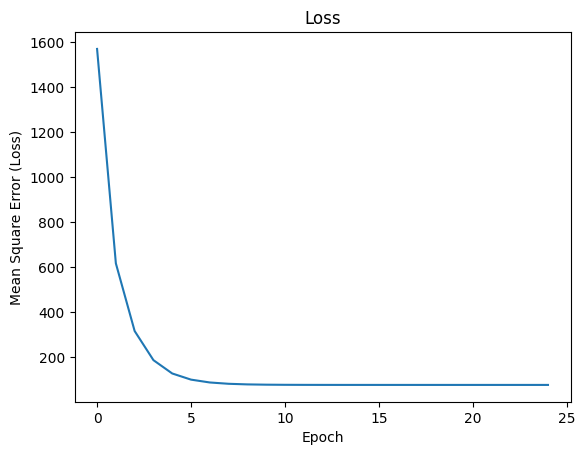

In [23]:
plt.title("Loss")
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error (Loss)');

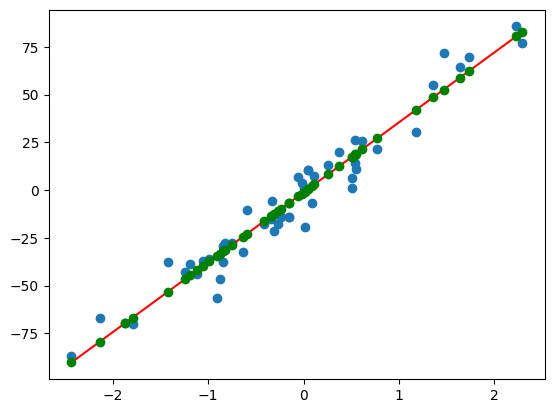

In [24]:
tt = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 10)
line_of_bf = weights[1]+weights[0]*tt
preds = model(torch.tensor(X).float().to(device)).cpu().detach().numpy()

plt.plot(X[:, 0], targets, 'o')
plt.plot(tt, line_of_bf, 'r-')
plt.plot(X[:, 0], preds, 'go')

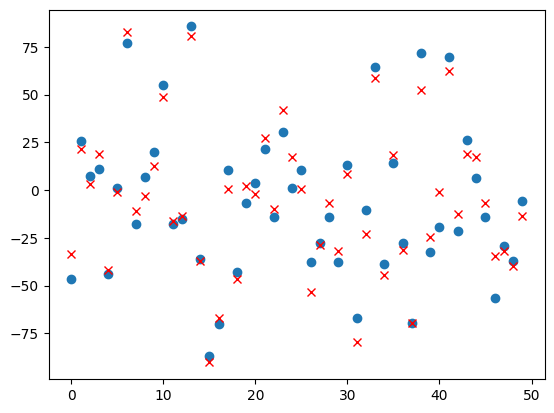

In [25]:
plt.plot(targets, 'o')
plt.plot(preds, 'rx')

Just like before let's take a look at each individual data sample as an individual optimization problem and see if we notice anything.

Remember that the below visualization shows us each individual sample's error (x-axis) and squared error (y-axis). This plot allows us to see how our weights are doing at finding the "minimum" error for each sample. Each data sample starts at an initial error (marked in green) and ends up at a final error (marked in blue) due to the optimization where some samples end up with a lower error while others even regress to a worse error than they started with!

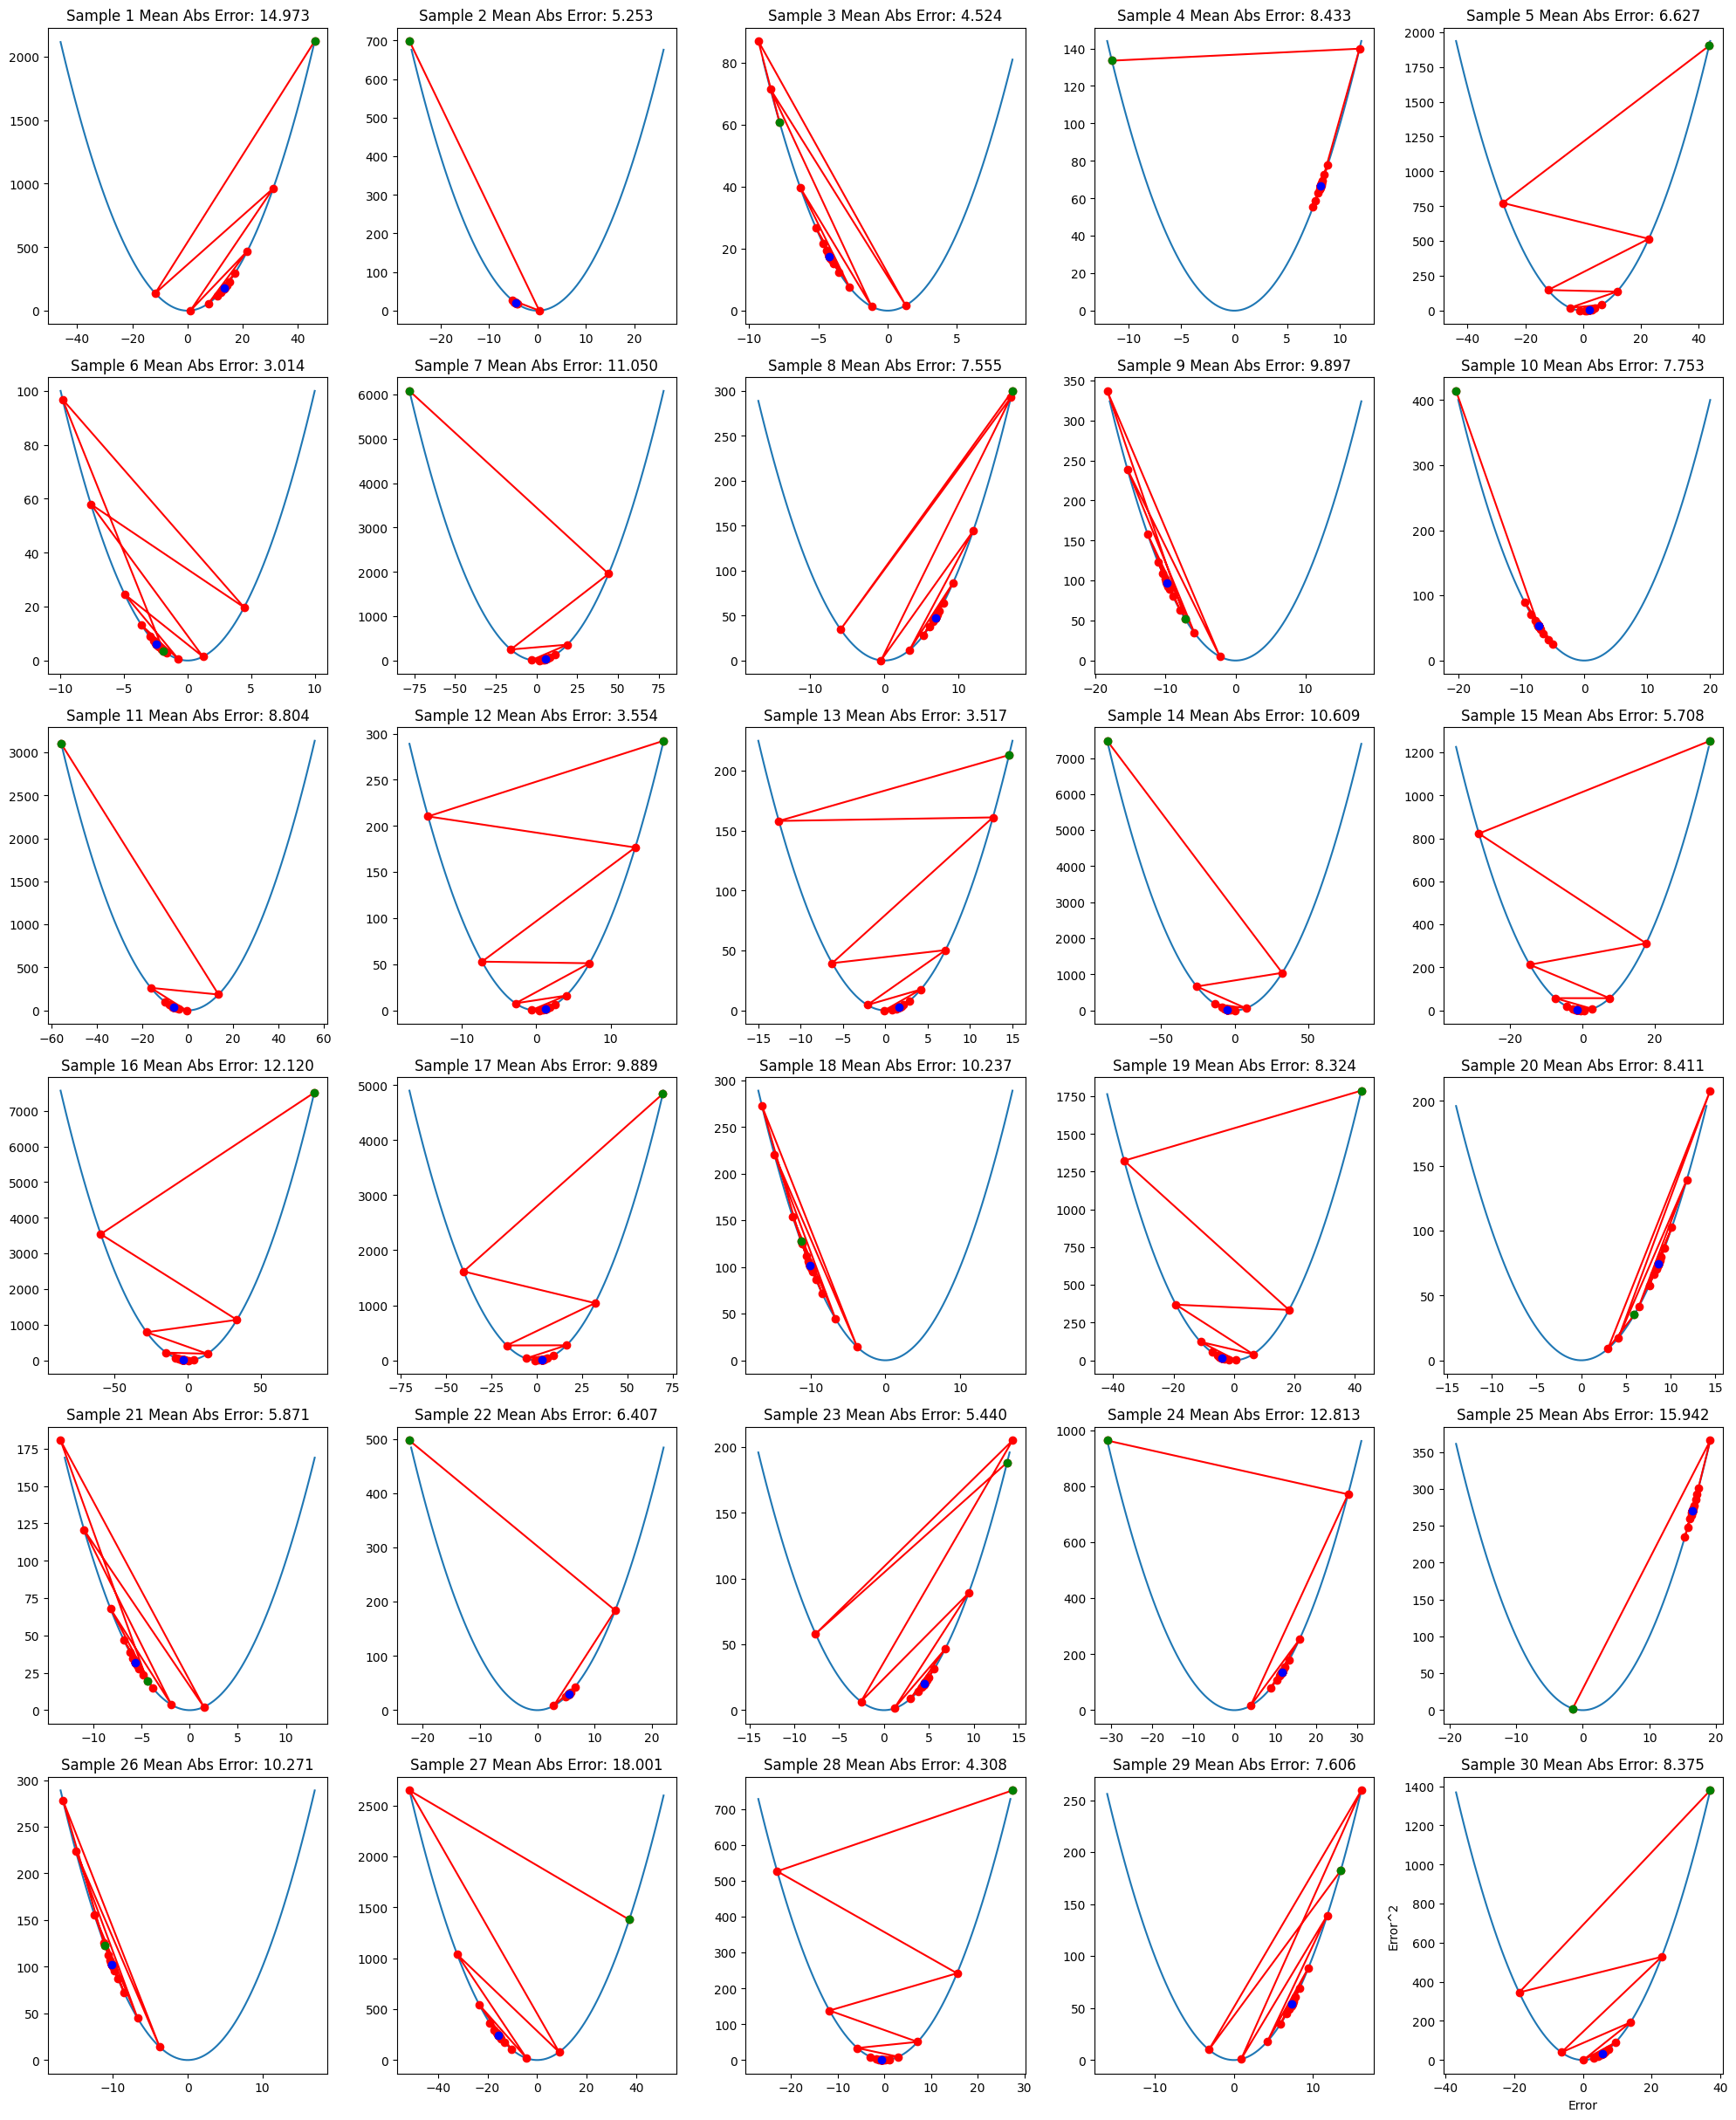

In [26]:
samples=30
cols = 5
rows = int(np.ceil(len(X) / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(20,40))
for i in range(samples):
    ax = fig.add_subplot(gs[i])
    smp_errors = errors[i]
    plot_function(f, 
                  min_ls=np.round(np.max(abs(smp_errors))), 
                  max_ls=-np.round(np.max(abs(smp_errors))), 
                  ax=ax)
    ax.plot(smp_errors, smp_errors**2, 'ro-')
    ax.plot(smp_errors[0], smp_errors[0]**2, 'go')
    ax.plot(smp_errors[-1], smp_errors[-1]**2, 'bo')
    ax.set_title("Sample {} Mean Abs Error: {:.3f}".format(i+1, np.abs(smp_errors).mean()))

plt.xlabel('Error')
plt.ylabel('Error^2')
fig.tight_layout()

Wow, each sample looks pretty unstable. This is what having vast changes in your gradient's sign looks like. It's interesting that our loss didn't reflect this large changes nearly as much. This means when you are debugging a neural network don't forget to pay attention to you gradients as the loss function doesn't always tell the full story!

While we still were able to come to a similar results as the smaller learning rate for more complex neural networks this is not usually the case. Some good default small learning rates you should usually use are .01, .001 or .0001 when training more complex neural networks!

# Building and Training a Deep Neural Network 

So far we have seen how to build a very basic linear neural network and how we use gradient descent with a loss to learn the network weights/parameters. Now, let's see if we can build an actual deep neural network with PyTorch while using FastAI to make training easy!

Wait...what exactly is FastAI again? Well, here is what FastAI claims to be:

> fastai is a deep learning library which provides practitioners with high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains, and provides researchers with low-level components that can be mixed and matched to build new approaches. It aims to do both things without substantial compromises in ease of use, flexibility, or performance. This is possible thanks to a carefully layered architecture, which expresses common underlying patterns of many deep learning and data processing techniques in terms of decoupled abstractions. These abstractions can be expressed concisely and clearly by leveraging the dynamism of the underlying Python language and the flexibility of the PyTorch library.

Essentially, FastAI is a high-level deep learning library that uses PyTorch to make deep learning easier and more accessible for those from different disciplines or new simply new to deep learning. To find out more about FastAI see their [docs](https://docs.fast.ai/).

We are going to use it because FastAI implements deep learning trends and does a lot of the more tedious tasks like training, data loading, data pre-processing and visualizations for us! However, it is easy to get lost in what FastAI's high-level API is doing, so we will do our best to explain.

Below is an example of FastAI's API structure. For now we are going to be working with the high-level API (the `Leaner` and `DataBlock` classes) which is directed towards certain applications (vision, text, tabular and collaborative filtering). If your application requires more low level manipulations, using FastAI's mid-level and low-level API can be very useful. For now, we want FastAI to do all the heavy lifting so its high-level API for us.

<center>
<img src="https://docs.fast.ai/images/layered.png" width=300 height=300>
</center>

## Data Loading and Pre-processing With FastAI

Before we start we need to load data to work with to train our neural networks. Let's do so my using FastAI's super convenient but slightly under documented API. The below are some imports we will be needing through the lab from FastAI.

As a side note, if you ever see a function or class that you have no clue where it was defined it is most likely a FastAI  function or class. Since we use `import *` we import all functions and classes from the given FastAI modules (sub-libraries). Normally, `import *` is poor practice but FastAI has specifically built their library to make it more efficient.

In [27]:
from fastai.vision.all import *
from fastai.data.all import *

/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.9/dist-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


The dataset we are going to be working with is the [MNIST dataset](https://wiki.pathmind.com/mnist). This is the hello world dataset for machine learning. **MNIST is a classification dataset** that contains handwritten digits where the goal is to classify each images as its intended number!

Below, we can see FastAI as pulled the MNIST data by using the `untar_data()` function which can pull any dataset from the web. Additionally, `URLs.MNIST` is a preset URL to the MNIST dataset that FastAI has set for us already. 

The `untar_data()` function returns a Python Path object ([docs](https://docs.python.org/3/library/pathlib.html)), not the data itself. We can use the path to navigate to the training and testing data which can be loaded either on demand or all at once using FastAI.

In [28]:
# dest="/content/"
path = untar_data(URLs.MNIST)
# Old code to be replaced
#train_path, test_path = path.ls()
# new modified codes
for p in path.ls():
    if str(p).endswith('testing'):
        test_path = p
    elif str(p).endswith('training'):
        train_path = p

print("File path for train data: {}".format(train_path))
print("File path for test data: {}".format(test_path))

File path for train data: /root/.fastai/data/mnist_png/training
File path for test data: /root/.fastai/data/mnist_png/testing


The MNIST data we downloaded is setup such that all the training data is located in the "../training/" directory and all the testing data is stored in the "../testing/" directory. Likewise, each class has its own directory. For instance, the train data for the 0 class is located at "../training/0". We can use Python to navigate to the 0 class by simply doing the following.

In [29]:
zero_training_samples = train_path / '0'
zero_training_samples

Path('/root/.fastai/data/mnist_png/training/0')

We can then call the `ls()` method on `zero_training_samples` to glimpse at all the training image paths for class 0.

In [30]:
zeros_path = zero_training_samples.ls().sorted()
zeros_path

(#5923) [Path('/root/.fastai/data/mnist_png/training/0/1.png'),Path('/root/.fastai/data/mnist_png/training/0/1000.png'),Path('/root/.fastai/data/mnist_png/training/0/10005.png'),Path('/root/.fastai/data/mnist_png/training/0/10010.png'),Path('/root/.fastai/data/mnist_png/training/0/10022.png'),Path('/root/.fastai/data/mnist_png/training/0/10025.png'),Path('/root/.fastai/data/mnist_png/training/0/10026.png'),Path('/root/.fastai/data/mnist_png/training/0/10045.png'),Path('/root/.fastai/data/mnist_png/training/0/10069.png'),Path('/root/.fastai/data/mnist_png/training/0/10071.png')...]

We can use the `Image` class from the Pillow library to quickly display what one of these image looks like! For those that don't know, Pillow is the is the go to Python library for handling images.

In [31]:
from PIL import Image
zero_img = Image.open(zeros_path[0])
zero_img

We can take a more zoomed in look at the image to notice few import aspects about the image. First thing to notice is that each pixel is an entry in our table below and each pixel seems to be an integer. Further note that the image dimensions are 1x28x28 and we are plotting the image in grayscale such that each pixel represents the intensity of gray where the max value is 255. 

**Keep the 1x28x28 dimensions in mind because we'll need to know them when designing a network! If you were wondering the 1 is the number of color channels, since our image is grayscale we only have 1 color channel.**

In [32]:
df = pd.DataFrame(np.array(zero_img))
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,159,253,159,50,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,238,252,252,252,237,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,54,227,253,252,239,233,252,57,6,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,10,60,224,252,253,252,202,84,252,253,122,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,163,252,252,252,253,252,252,96,189,253,167,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,51,238,253,253,190,114,253,228,47,79,255,168,0,0,0,0,0,0


It's time for us to load all our MNIST data. To do so we are going to use the FastAI `DataBlock` class which allows us define **how** to load our data from a file or a directory containing many files. Further, it let's us specify any transformations or pre-processing steps we might want to apply to the data! This means once we load in our data it is ready to be used for training!

Let's start by breaking down what is being passed to each parameter of the `DataBlock` given the below code. There is a lot happening here in just a few lines of code so if you don't fully understand right away don't worry as we will be practicing more of this data loading in the future.

**Note, we have replaced the variables in the below code description with their actual values so we can easily refer to the classes and functions that are being stored inside them!!!!**

> `blocks=(ImageBlock(cls=PILImageBW), CategoryBlock)`
> - The `blocks` parameter is an essential parameter which defines how to store and pre-process our input data and targets once loaded.
> - The `ImageBlock` is a FastAI class that  is specialized for loading and pre-processing image data. Since the MNIST data contains images, we call the `ImageBlock` class which will store our images as `PILImageBW`. `PILImageBW` is just a FastAI wrapper for the PIL `Image` class and automatically converts our images to black and white. Further, `ImageBlock` converts all our images to floats and divides by 255 when a mini-batch of data is taken. We do this to normalize our pixel values and we need to convert them to floats otherwise PyTorch will throw errors later when we train using our data. We'll take a deeper look at this classes and pre-processing steps more in the next lab.
> - The `CategoryBlock` simply wraps our labels in a PyTorch Tensor.

> `get_items=get_image_files,`
> - The `get_items` parameter takes in a function that tells the `DataBlock` which files to load. We pass FastAI's `get_image_files` ([docs](https://docs.fast.ai/data.transforms.html#get_image_files)) which produces a list of paths to all the images in a given directory.

> `splitter=RandomSplitter(valid_pct=.2, seed=1)`
> - The `splitter` parameter determines how to split the loaded data into both a training and validation set. We pass the `RandomSplitter` FastAI class which randomly splits the data using a 80/20 split. In other words, 80% of the data is used for training and validation. We do so by setting the `RandomSplitter` parameter of `valid_pct` equal to .2.  Further, we set a seed such that everytime we rerun the code the split remains the same, this is done for reproducibility concerns.

> `get_y=parent_label` 
> - The `get_y` parameter tells the `DataBlock` how to label each data sample. Recall that a data sample's label is given by the parent directory. In other words, all the 0 samples are stored in a directory called "0". The FastAI `parent_label()` function ([docs](https://docs.fast.ai/data.transforms.html#parent_label)) tells the `DataBlock` to label the image given the name of the parent directory. 

For those looking for a deep understanding of `DataBlock` and what is happening see this [video](https://www.youtube.com/watch?v=pQ7CJzGn6YE&t=3151s) which breaks down FastAI's internal API a little more. Further, the following tutorials can be pretty useful: 
- [Finding DataBlock Nirvana with fast.ai v2](https://ohmeow.com/posts/2020/04/11/finding-datablock-nirvana-part-1.html)
- [Building an image classifier using Fastai V2](https://harish3110.github.io/through-tinted-lenses/computer%20vision/image%20classification/2020/03/29/Building-an-image-classifier-using-Fastai.html)
-[Fastbook: part 5 image classification](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb)

In [33]:
valid_split = .2
seed = 1
data_block = ImageBlock(cls=PILImageBW)
target_block = CategoryBlock()

trn_mnist_db = DataBlock(blocks=(data_block, target_block),
                         get_items=get_image_files,
                         splitter=RandomSplitter(valid_pct=valid_split, seed=seed),
                         get_y=parent_label
                        )

Notice, nothing has been loaded yet. This is because `DataBlock` simply specifies the instructions or steps for loading the data and what needs to be done to the data.

Let's actually load our data now. All we need to do is specify the directory path where all our data is stored. Recall we pathed to the MNIST training data and store the path inside `train_path`. All we have to do now is pass `train_path` to the `.dataloaders()`  for our `DataBlock` instance variable `trn_mnist_db` and pass a mini-batch size. Wait...but what is a mini-batch size?

**What is a mini-batch and why do we need it?**

Since our data can be really big both in the number of data samples and in the number of features, especially images, passing all our data at once can take a really long time and is sometimes not even possible due to memory constraints. Instead we opt to pass only small groups of our data to neural network which it then uses to update our weights. These small groups of data are referred to as **mini-batches**.

Given our full dataset we can then break our data into batches of a given size. Some good default mini-batch sizes 32, 64, 128, and 256, although mini-batch sizes can be much large. Keep in mind the size of your mini-batch will affect the speed of learning. Small mini-batches tend to cause slower learning while larger mini-batches tend to speed up training.

Mini-batch sizes have much more implications, like how mini-batch size and learning rate interact, and finding the right mini-batch size is actually non-trivial, but this high-level idea of mini-batches should suffice for now.

- References
    - [A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)
    -[What is a minibatch in a neural network?](https://www.quora.com/What-is-a-minibatch-in-a-neural-network?share=1)

In [34]:
batch_size = 256
trn_vld_dls = trn_mnist_db.dataloaders(train_path, bs=batch_size)

If we don't want to load our data but preform a dry run of loading our data to see if any errors occur, we can use  the `.summary()` and pass it to the directory or file path containing our data, in our case `train_path`. Furthermore, `.summary()` method will specify all the preprocessing steps that are going to be applied to our data such that we can double check everything is going as planned. This method is really useful for debugging!

The first part of the output indicates to use the pipelines that will be applied to each of our blocks we passed. We can see our data block pipeline is `Setting up Pipeline: PILBase.create` and our target pipeline is `Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}`. Additionally, it shows how many files are found `Found 60000 items` and how the data will be split `2 datasets of sizes 42000,18000`.
```
Setting-up type transforms pipelines
Collecting items from /home/dev/.fastai/data/mnist_png/training
Found 60000 items
2 datasets of sizes 48000,12000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
```

Next, the summary tries to build our actual data and targets using the defined pipelines. We can see in the line marked `Final sample` that each data sample is converted into a `PILImageBW` and paired with its corresponding label.

```
Building one sample
  Pipeline: PILBase.create
    starting from
      /home/dev/.fastai/data/mnist_png/training/6/47376.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/dev/.fastai/data/mnist_png/training/6/47376.png
    applying parent_label gives
      6
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(6))

```

The next most important output deals with building a batch. Recall that the `ImageBlock` contains transforms that convert our integers to floats and divides each pixels in our image by 255 ONLY when a batch is taken. We can this happening in the  `Setting up after_batch: ` pipeline. Notice `IntToFloatTensor` is the transform which does the aforementioned conversion and division for us!

```
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImageBW mode=L size=28x28, TensorCategory(6))
    applying ToTensor gives
      (TensorImageBW of size 1x28x28, TensorCategory(6))
```

In [35]:
trn_mnist_db.summary(train_path)

Setting-up type transforms pipelines
Found 60000 items
2 datasets of sizes 48000,12000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/5/44820.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/mnist_png/training/5/44820.png
    applying parent_label gives
      5
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(5)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(5))


Found 60000 items
2 datasets of sizes 48000,12000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipelin

Annnnnd we are done loading our data. The `ImageDataLoaders` class has now loaded all our data from their paths, labeled said data based on the parent path name, split our data  into training and validation sets, and partitioned each training and validation datasets into batches! On top of that FastAI also automatically pulled the MNIST dataset for us and unzipped it. Now do you see why we are using FastAI?

Well that is all great but where is our data, how do we interact with it, and what is a `DataLoaders`!? Well, for starters, a `DataLoaders` is a FastAI class that is needed for our `Learner` function later on which will train our neural network. The main purpose of a `Dataloaders` is...well, to load data into our model. Let's take some time to go through the important attributes and functions that the base `DataLoaders` class has to offer us and see how it works.

First of all, where is our train and validation data? The answer to that question is actually easy. We have direct access to the train and validations data by simply doing `DataLoaders.train_ds` and `DataLoaders.valid_ds`.

In [36]:
trn_vld_dls.train_ds

(#48000) [(PILImageBW mode=L size=28x28, TensorCategory(5)),(PILImageBW mode=L size=28x28, TensorCategory(6)),(PILImageBW mode=L size=28x28, TensorCategory(6)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(2)),(PILImageBW mode=L size=28x28, TensorCategory(9)),(PILImageBW mode=L size=28x28, TensorCategory(6)),(PILImageBW mode=L size=28x28, TensorCategory(8)),(PILImageBW mode=L size=28x28, TensorCategory(9)),(PILImageBW mode=L size=28x28, TensorCategory(2))...]

In [37]:
trn_vld_dls.valid_ds

(#12000) [(PILImageBW mode=L size=28x28, TensorCategory(6)),(PILImageBW mode=L size=28x28, TensorCategory(9)),(PILImageBW mode=L size=28x28, TensorCategory(8)),(PILImageBW mode=L size=28x28, TensorCategory(9)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(2)),(PILImageBW mode=L size=28x28, TensorCategory(1)),(PILImageBW mode=L size=28x28, TensorCategory(9)),(PILImageBW mode=L size=28x28, TensorCategory(6)),(PILImageBW mode=L size=28x28, TensorCategory(9))...]

Now before you get lost in all the output we have actually seen most of these data objects being displayed. FastAI likes to store samples in tuples such that our data samples is paired with its label!

First, the object that wraps all the data is a FastAI data object called `L` which stores our train and validation data. You can treat this `L` data object just like a Python list essentially. Notice, each element of the `L` data object contains a data sample `PILImage mode=RGB size=28x28` and a label `TensorCategory()`. 

Hmmm haven't we seen these objects before? Yes! These are just the objects we specified for our `DataBlock` class using the `blocks` parameter! If you don't remember, go back and check out the `DataBlock` code and explanation again. 

Let's take a closer look at the first sample for the training dataset.

In [38]:
trn_vld_dls.train_ds[0]

(PILImageBW mode=L size=28x28, TensorCategory(5))

See, we index the `train_ds` object just like a list and it returns a tuple containing the data and label. Now it stores our data as a `PILImage` which is a data object from the Pillow library which is popular for manipulating images in Python. If we index the `PILImage` data sample directly by doing `trn_vld_dls.train_ds[0][0]` we will see that the `PILImage` class will automatically display our data sample for us like before!

In [39]:
trn_vld_dls.train_ds[0][0]

Well, what is a `TensorCategory`? The`TensorCategory` is just a FastAI wrapper for a PyTorch tensor specifically designed for storing the labels. This might explain why it is holding our data sample's label. 

In [40]:
trn_vld_dls.train_ds[0][1]

TensorCategory(5)

Hmmm but if our data is store in a `PILImageBW` object how can we pass it to our neural network which only takes PyTorch tensors?

Luckily, we don't have to worry about converting our data samples stored as `PILImageBW` to a PyTorch tensor at train time as FastAI does that for us. We can confirm this by viewing a random training batch. Notice it displays all the batch data as a `TensorImageBW` and also displays the corresponding labels as a `TensorCategory`. All these are are FastAI wrappers for actual PyTorch tensors. 

In [41]:
rnd_train_batch = trn_vld_dls.one_batch()
rnd_train_batch

(TensorImageBW([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
      

Viewing the raw tensor is actually not a great way of viewing our batch. Once again FastAI steps in and allows us to plot our batches so we can see what is going on within our data!

Below, we can visualize our `rnd_train_batch` by simply calling the `show_batch()` method ([docs](https://docs.fast.ai/data.core.html#TfmdDL.show_batch)) for our `DataLoaders`. By default `show_batch()` will only show the first 9 images of our batch but we can change that by setting the `max_n` parameter. Note that we also pass our `rnd_train_batch` directly to the `show_batch()`function otherwise it will display a random batch from the training data.

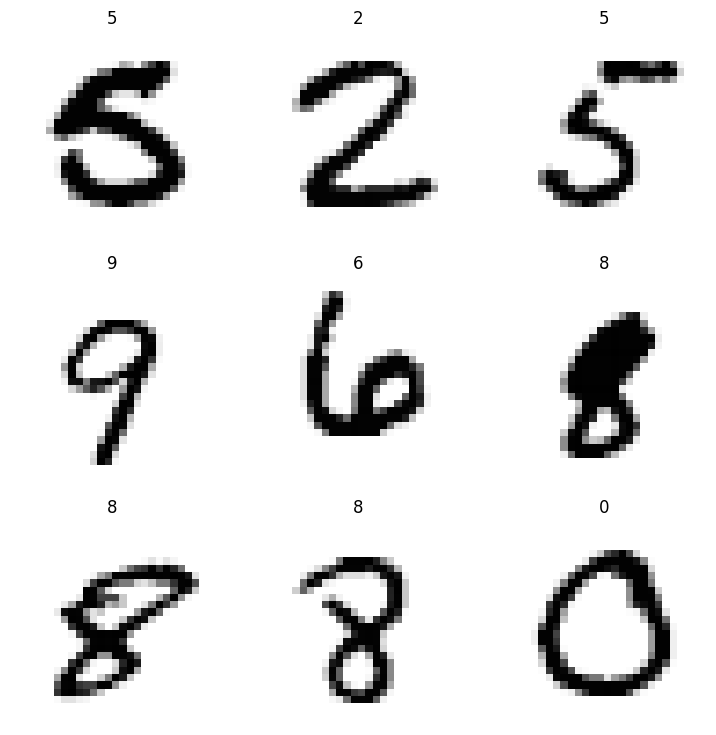

In [42]:
trn_vld_dls.show_batch(b=rnd_train_batch)

Next, let's review the shape of our data as this will have some implications later on with our model.

In [43]:
trn_vld_dls.one_batch()[0].shape

torch.Size([256, 1, 28, 28])

Our batch data has 4 dimensions `[batch size, channels, width, height]` as seen below! The first dimension is the number of samples in the batch, and the second dimension is the number of color channels. Since we loaded our image using `PILImageBW`, our images are grayscale and only contain one color channel, normally we would have three color channels. The last two dimensions are the dimensions of each image.

Wait a second, how can we pass a 4 dimensional batch to a neural network? Normal neural networks only take 2 dimensions `[batch size, features]`. We will look at how to overcome this problem shortly.

Lastly, we need to load in our test data. Recall that we stored the path to all the test data in the `test_path` variable. We need to use this path to load in all our test data. 

In [44]:
test_path

Path('/root/.fastai/data/mnist_png/testing')

<div id="TODO3"></div>

#### TODO 3

Loading of test data is a relatively straight forward process and it turns out we don't actually need to make another `DataBlock`. Instead, we can use the special method `.test_dl()` which is a part of our `DataLoaders` class. This method creates a new `DataLoader` given some data or data paths and applies all the transformations/pre-processing steps that were applied to our validation data. 

Note the focus on the validation transformations or pre-processing steps is because, typically, validation and test data use the same transformations, however train data can sometimes use different transformations specific to training.

Now it's your turn, load in the test data using the following instructions. Let's start by running the `doc(trn_vld_dls.test_dl)` which will pull up the documentation for the `.test_dl()` method so we know what we need to pass to it. This `doc()` command is a FastAI function that only works on FastAI functions, alternatively you can use the `?` to see the documentation of any function or class and `??` to see the source code.

Given the documentation we need to at least pass a parameter called `test_items`. It  turns out `test_items` can be either data or a list of paths to data. Now didn't we have a FastAI function that created a list of paths to all the images in a given directory? We did, it was called  `get_image_files()`.

1. Let's start off my passing our test data path directory `test_path` to `get_image_files()`. Store the output into `test_files`.

Okay, now it's time to load our test data since we have all the paths to the test images!

2.  To do so we need to call the `.test_dl()` method on our `DataLoaders` instance `trn_vld_dls` and `test_files`. Store the output into `test_dl`.

Wait a second. If we look closely at the output we are missing something, we are missing our labels! There must be a parameter to specify we want our labels right?

3. Use the FastAI documentation ([docs](https://docs.fast.ai/data.core#DataLoaders.test_dl)) for the `.test_dl()` method to find the parameter that allows us to load our data and the corresponding label. Once you have found the parameter call the `.test_dl()` method again. Store the output into `test_dl`.
    1. Hint: We know the FastAI documentation is pretty sparse at the moment as they just released version 2.0 but the name of the parameter should give itself away.

In [45]:
# trn_vld_dls.test_dl??
# trn_vld_dls.test_dl?
doc(trn_vld_dls.test_dl)

DataLoaders.test_dl(test_items, rm_type_tfms=None, with_labels=False, bs=64, shuffle=False, num_workers=None, verbose=False, do_setup=True, pin_memory=False, timeout=0, batch_size=None, drop_last=False, indexed=None, n=None, device=None, persistent_workers=False, *, wif=None, before_iter=None, after_item=None, before_batch=None, after_batch=None, after_iter=None, create_batches=None, create_item=None, create_batch=None, retain=None, get_idxs=None, sample=None, shuffle_fn=None, do_batch=None)
Create a test dataloader from `test_items` using validation transforms of `dls`

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [46]:
# TODO 1
test_files = get_image_files(test_path)
test_files

(#10000) [Path('/root/.fastai/data/mnist_png/testing/3/6381.png'),Path('/root/.fastai/data/mnist_png/testing/3/1028.png'),Path('/root/.fastai/data/mnist_png/testing/3/1615.png'),Path('/root/.fastai/data/mnist_png/testing/3/9680.png'),Path('/root/.fastai/data/mnist_png/testing/3/7656.png'),Path('/root/.fastai/data/mnist_png/testing/3/1765.png'),Path('/root/.fastai/data/mnist_png/testing/3/3686.png'),Path('/root/.fastai/data/mnist_png/testing/3/2522.png'),Path('/root/.fastai/data/mnist_png/testing/3/8603.png'),Path('/root/.fastai/data/mnist_png/testing/3/1531.png')...]

In [47]:
# TODO 2
test_dl = trn_vld_dls.test_dl(test_files) #, test_files.test_dl
test_dl.dataset

(#10000) [(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,)...]

In [48]:
# TODO 3
test_dl = trn_vld_dls.test_dl(test_files, get_y = parent_label)
test_dl.dataset

(#10000) [(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,),(PILImageBW mode=L size=28x28,)...]

##  Building and Training a Neural Network

 Now that we have loaded all our data, finally, we can begin building our neural networks! However, before that we need to talk about two different ideas we have addressed yet: 
1. How can we reshape our data such that we have 2 dimensions per batch instead of 4.
2. What type of loss can we use for classification? Remember our problem isn't a regression problem so we can't use mean squared error!

### (1) Flattening Our Data

Recall that our mini-batch has the below shape. The issue here is that basic neural networks can only take two dimensional data `[batch_size, number of features]`. We currently have `[batch size, channels, width, height]`. What we need to do is called flattening where we combine or flatten certain dimensions into one dimension.

In [49]:
trn_vld_dls.one_batch()[0].shape

torch.Size([256, 1, 28, 28])

Below is an example of what flattening does. Notice we have compressed the 1st, 2nd, and 3rd dimensions into one. Notice the total size of the new dimensions size is $784=1*28*28$ or the product of the combined dimensions.

In [50]:
trn_vld_dls.one_batch()[0].flatten(start_dim=1).shape

torch.Size([256, 784])

We can apply this idea either at the data loading level (flatten our images upon being loaded) or at the model level (have our model automatically flatten any input). Both have their advantages and disadvantages. However, since we want to keep the wonderful visualization the FastAI has to offer which requires having 4 dimensions we'll fix this issue at the model level.

<div id="TODO4"></div>

#### TODO 4

It turns out PyTorch has a wonderful neural network layer called `Flatten` which does exactly this! 

1. Define the PyTorch `nn.Flatten` layer object and store the output into `flatten_layer`
2. Pass one batch of data from our training data using `trn_vld_dls.one_batch()` to the `flatten_layer` and observe the output shape.
    1. Hint: Be sure to only pass the data from returned from the `.one_batch()` method. Recall that the `.one_batch()` method returns BOTH the data and the targets and we only want the data!
3. Describe each dimension of the output shape for `flatten_output`. What is the first dimension? What is the second dimension? How do we compute the size of the second dimension?

In [51]:
# TODO 1
flatten_layer = nn.Flatten()
# TODO 2
flatten_output = flatten_layer(trn_vld_dls.one_batch()[0])
flatten_output.shape

torch.Size([256, 784])

```
Todo 3 Question: 

Describe each dimension of the output shape for `flatten_output`. What is the first dimension? What is the second dimension? How can we compute the size of the second dimension?
```

```
Answer below:
```
The first dimension is 256 and the second one is 784. 


### (2) Classification Loss

Alright, how do we deal with our next problem of finding a loss that is made for classification problems? Well, there are really two issues here. 

#### Softmax
We have 10 classes (there are 10 digits in the MNIST dataset and therefore 10 labels), therefore our last neural network layer outputs 10 values corresponding to the class labels. However, these values will just be arbitrary numbers on the continuous number scale. The question is then, how do we make the output more meaningful? This is where the activation layer called Softmax ([wiki](https://en.wikipedia.org/wiki/Softmax_function)) comes in. 

We won't get into the details of the Softmax as we used it for logistic regression earlier in the semester. Recall, that the Softmax takes in a set of numbers (known as logit) and outputs a probability distribution over said numbers. In other words, it turns our numerical outputs into probabilities!

This means that our network will now output the probability that an input image belongs to a certain class! In order to make a prediction, we can take the `argmax` over the Softmax outputs to get the class label. 

<img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fsefiks.com%2Fwp-content%2Fuploads%2F2017%2F11%2Fsoftmax1.png&f=1&nofb=1">

<div id="TODO5"></div>

#### TODO 5
Given this idea of Softmax, let's create a Softmax layer and pass some toy data through it to reaffirm what it is doing!

1. Using PyTorch create a `nn.Softmax` layer ([docs](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)) and store the output into `softmax_layer`
2. Pass `rand_values` to the softmax layer `softmax_layer` and store the output into `softmax_output`. Take a second to observe the outputs and see what you notice before moving on.

In [52]:
rnd_values = torch.tensor([2, 1, .1]).float()
rnd_values

tensor([2.0000, 1.0000, 0.1000])

In [53]:
# TODO 1
softmax_layer = nn.Softmax()
# TODO 2
softmax_output = softmax_layer(rnd_values)
softmax_output

<ipython-input-53-b646344422b2>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_output = softmax_layer(rnd_values)


tensor([0.6590, 0.2424, 0.0986])

Notice that larger numbers get larger probabilities and smaller numbers get smaller probabilities. Also notice that the output of the Softmax sums to 1!

In [54]:
softmax_output.sum()

tensor(1.0000)

Also we can see what the predicted class would be. In this toy example case class 0 has the highest probability therefore it would be the predicted class.

In [55]:
softmax_output.argmax()

tensor(0)

#### Negative Log Likelihood (NLL) Loss

Cool so we now know how to get the probability that the neural network thinks an image belongs to a certain class. However, we are still left with the issue of what loss do we use?

Well, the solution to this problem lies in the negative log likelihood (NLL) loss or otherwise known as cross-entropy. NLL is the go to loss for most basic classification problems. Now there is too much to cover about NLL and this lab is already ungodly long so we'll try to be brief.

NLL is given by the following equation (other versions exist but this is the more simplified one):

$-log(\hat{y})$

Here $\hat{y}$ represents the predicted probability for the target class. Now we are greatly simplifying this formula but all you need to know for now is that we take the the negative logarithm of the predicted probability that corresponds to the target class. In other words, if that target is say class 1 then we take the negative logarithm of the predicted probability for class 1. Let's use an example below.

Let's define some toy data to see how NLL loss works. Below we create some toy data which takes the log of the softmax output for 5 data samples (rows) each which could be one of 3 classes (columns). Note we use the `nn.LogSoftmax` layer because recall we need to take the log of the probabilities output which is what the `nn.LogSoftmax` layer does!

In [56]:
logsoftmax_layer = nn.LogSoftmax()
torch.manual_seed(0)
inputs = torch.randn(5, 3)
nn_logsoftmax_output = logsoftmax_layer(inputs)
nn_logsoftmax_output

<ipython-input-56-a3dc2e1a346a>:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  nn_logsoftmax_output = logsoftmax_layer(inputs)


tensor([[-0.1689, -2.0033, -3.8886],
        [-0.2862, -1.9392, -2.2532],
        [-1.0543, -0.6196, -2.1769],
        [-1.2865, -1.4797, -0.7011],
        [-2.1846, -0.2273, -2.3991]])

Notice our output is now the log of the softmax which isn't very interpretable. However, we can recover our probabilities by using the [logarithm definition](https://www.wikihow.com/Solve-Logarithms). Sense PyTorch logarithms use base `e` ([log docs](https://pytorch.org/docs/stable/generated/torch.log.html)) then we can easily recover the probabilities using the logarithm definition as seen below.

In [57]:
softmax_probs = torch.exp(nn_logsoftmax_output)
softmax_probs

tensor([[0.8446, 0.1349, 0.0205],
        [0.7511, 0.1438, 0.1051],
        [0.3484, 0.5382, 0.1134],
        [0.2762, 0.2277, 0.4961],
        [0.1125, 0.7967, 0.0908]])

Here we can see the predictions for each data sample in our mini-batch. Note that there are 3 class labels (0, 1, and 2).

In [58]:
preds = torch.argmax(nn_logsoftmax_output, axis=1)
preds

tensor([0, 0, 1, 2, 1])

Next, we generate some fake targets which tell use which class the data samples above actually belong to.

In [59]:
torch.manual_seed(2)
targets = torch.empty(5, dtype=torch.long).random_(3)
targets

tensor([0, 0, 2, 0, 2])

Here we define PyTorch's NLL Loss class. We set `reduce=False` for display purposes only, **DO NOT** use this parameter when using NLL as a loss for your neural network.

Below, we can see the loss for each data sample. 

In [60]:
nll_loss = nn.NLLLoss(reduce=False)
loss = nll_loss(nn_logsoftmax_output, targets)
loss

/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor([0.1689, 0.2862, 2.1769, 1.2865, 2.3991])

Now, what is happening? Recall, we are simply taking the log of the predicted probability that corresponds to each target for each data sample. Check out the output below which breakdowns of the process of computing NLL for each target and prediction.

In [61]:
for i, t in enumerate(targets):
    print("Target: {}".format(t))
    print("Predicted probability for target {}: {:.5f}".format(t, softmax_probs[i, t]))
    print("Log of probability log({:.5f}): {:.5f}".format(softmax_probs[i, t], 
                                                         nn_logsoftmax_output[i, t]))
    print("Negative log loss -log({:.5f}): {:.5f}".format(softmax_probs[i, t], 
                                                          loss[i]))
    print("-"*50)

Target: 0
Predicted probability for target 0: 0.84463
Log of probability log(0.84463): -0.16885
Negative log loss -log(0.84463): 0.16885
--------------------------------------------------
Target: 0
Predicted probability for target 0: 0.75111
Log of probability log(0.75111): -0.28620
Negative log loss -log(0.75111): 0.28620
--------------------------------------------------
Target: 2
Predicted probability for target 2: 0.11339
Log of probability log(0.11339): -2.17688
Negative log loss -log(0.11339): 2.17688
--------------------------------------------------
Target: 0
Predicted probability for target 0: 0.27625
Log of probability log(0.27625): -1.28645
Negative log loss -log(0.27625): 1.28645
--------------------------------------------------
Target: 2
Predicted probability for target 2: 0.09080
Log of probability log(0.09080): -2.39910
Negative log loss -log(0.09080): 2.39910
--------------------------------------------------


The major point to notice here is that smaller probabilities produce bigger losses and larger probabilities produce smaller losses. This means if the predicted probability for our target is really large then our loss is small. Likewise, if the predicted probability for our target is small then our loss is really large. This make sense as we want to increase the predicted probability of our target if it is small.

For instance, your loss is will be higher when your probability is 60% for the target class compared to if your probability was 95%. Although both are correctly classified, the lack of confidence or low probability increases the loss. 

Also note that all `nn.NLLLoss` is apply the negative to the output of `nn.LogSoftmax` Also `nn.NLLLoss` will compute the average loss over the entire mini-batch (5 samples) here which is what we want when using `nn.NLLLoss` in our neural networks.

In [62]:
avg_nll_loss = nn.NLLLoss()
avg_loss = avg_nll_loss(nn_logsoftmax_output, targets)
print("Average loss over mini-batch: {:.5f}".format(avg_loss))

Average loss over mini-batch: 1.26350


### Building a Basic Neural Network
Given we have an idea of how to flatten our data and compute the loss for classification data let's finally build some neural networks.



<div id="TODO6"></div>

#### TODO 6
Let's start off by not over engineering and creating network worth 2 hidden layers. You'll need to specify the in and out feature sizes for each layer excluding the `Flatten`, `ReLU`, and `Softmax` layers.

**Warning: This may take a 5+ minutes to run and MUCH longer if you aren't using a GPU.**

1. Define an PyTorch neural network using the `nn.Sequential`.
    1. First add a `nn.Flatten` layer to our network to flatten the inputs.
    2. Next, define the first linear `nn.Linear` hidden layer with 64 hidden units that is followed by a `ReLU` activation function. 
        1. Think about what the input size of the linear layer should be! We calculated it a while back! 
    3. Once again, define the second linear `nn.Linear` hidden layer with 64 hidden units that is followed by a `ReLU` activation function.
    4. Additionally, define the output layer  `nn.Linear` where the number of hidden units is equal to the number of classes in our MNIST dataset. This output layer should be followed by a `nn.LogSoftmax` layer to turn our outputs into probabilities.
    5. Finally, be sure to use `.to(device)` to move our model to the correct device!
2. Declare the `NLLLoss` class and store the output into `nll_loss`.
3. Using the `summary()` function imported from the `torchsummary` module earlier, how many total trainable parameters or weights do we have? 
4. Call `.fit()` method on `learn` which is an instance of `Learner`. Pass 5 epochs and a learning rate of .1 to the method as well. 

In [63]:
# TODO 1 
hu = 64;
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=784),
    nn.ReLU(),
    nn.Linear(in_features = 784, out_features = hu),
    nn.ReLU(),
    nn.Linear(in_features=hu, out_features=hu),
    nn.LogSoftmax()
).to(device)

# TODO 2
nll_loss = nn.NLLLoss()

learn = Learner(trn_vld_dls, model, opt_func=SGD, loss_func=nll_loss, metrics=accuracy)

In [64]:
summary(model, trn_vld_dls.one_batch()[0].shape[1:]);

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
            Linear-4                   [-1, 64]          50,240
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 64]           4,160
        LogSoftmax-7                   [-1, 64]               0
Total params: 669,840
Trainable params: 669,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.56
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


```
TODO 3 - Question:
Using the `summary()` function imported from the `torchsummary` module earlier, how many total trainable parameters or weights do we have? 
```

```
TODO 3 - Answer:
```
We have a total of 669,840 params with a size of 2.56 MB. And a total of 669,840 trainable params

In [65]:
# TODO 4
learn.fit(5, lr = 0.1);

epoch,train_loss,valid_loss,accuracy,time
0,0.640858,0.453445,0.872750,00:59
1,0.353243,0.352550,0.898667,00:54
2,0.293041,0.317052,0.910000,00:50
3,0.251974,0.268021,0.927333,00:50
4,0.215731,0.232028,0.935167,00:51


Alright, if we look at the table produced by FastAI's `Leaner` class when we called the `.fit()` method we can see each epoch and the train loss, validation loss, accuracy, and time it took to pass over all the train and validation data. So far for such a simple model, we are doing pretty good! You should see that we are achieving accuracy in the mid 90s!

Let's take a closer look at how the model is doing. The next thing we can do is plot the losses for every batch to see how our model improves over time. We do so by using the `learn.recorder.plot_loss()` method!

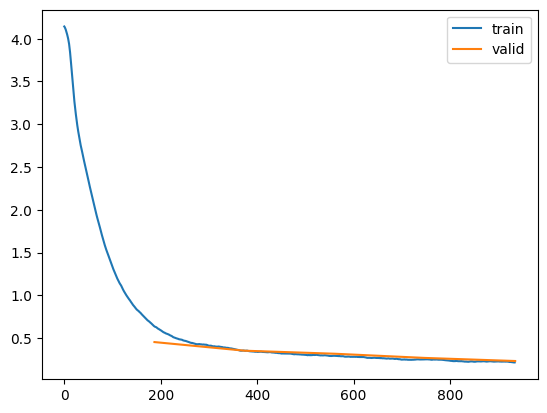

In [66]:
learn.recorder.plot_loss(skip_start=0)

As we can see our train and validation losses slowly decrease overtime and are actually quite close to one another!

Further if you need to get the predictions for the validation data you can simply call `learn.get_preds()` which will return the output of the network and the targets for the validation data ONLY. We can take the `argmax` of the output to get the predictions for the validation data as well!

In [67]:
# Get validation probs and targets
vld_logprobs, vld_targets = learn.get_preds()
vld_loss, vld_acc = learn.validate()
vld_preds = vld_logprobs.argmax(axis=1)
print("Validation loss: {:.5f} accuracy: {:.5f}".format(vld_loss, vld_acc))
vld_preds

Validation loss: 0.23203 accuracy: 0.93517


tensor([6, 9, 8,  ..., 8, 9, 3])

Further, we can do a quick comparison to see how many examples we got wrong.

In [68]:
vld_incorrect_preds = torch.where((vld_targets == vld_preds) == False)[0]
print("Number of validation data samples misclassified: {}".format(len(vld_incorrect_preds)))

Number of validation data samples misclassified: 778


Next, we can take an even more detailed look at the classification break down by using FastAI to automatically plot a confusion matrix for us. Note that the main diagonal shows samples that were correctly classified and the off diagonal represents the samples that are misclassified.

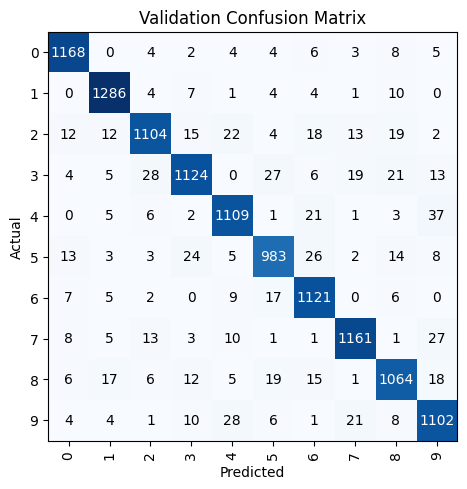

In [69]:

vld_interp = ClassificationInterpretation.from_learner(learn)

# We need this line or FastAI will throw an Assert error about dimensions not matching!
vld_interp.decoded = vld_interp.decoded.argmax(axis=1)

vld_interp.plot_confusion_matrix(title="Validation Confusion Matrix")

Now let's do the same visualizations for our test data! Note that all we have to do is use the same methods but now we have to pass the `test_dl` we defined earlier as a parameter!

In [70]:
tst_logprobs, tst_targets = learn.get_preds(dl=test_dl)
tst_loss, tst_acc = learn.validate(dl=test_dl)
tst_preds = tst_logprobs.argmax(axis=1)
print("Test loss: {:.5f} accuracy: {:.5f}".format(tst_loss, tst_acc))
tst_preds

TypeError: ignored

In [71]:
tst_incorrect_preds = torch.where((tst_targets == tst_preds) == False)[0]
print("Number of test data samples misclassified: {}".format(len(tst_incorrect_preds)))

TypeError: ignored

In [ ]:
tst_interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)

# We need this line or FastAI will throw an Assert error about dimensions not matching!
tst_interp.decoded = tst_interp.decoded.argmax(axis=1)

tst_interp.plot_confusion_matrix(title="Test Confusion Matrix")

### Trying a Different Optimizer

Now let's try changing our optimizer to a more modern day optimizer. While stochastic gradient descent seems to do a descent jobs in recent years there have been many new variants of optimizers that attempt built up the basics of stochastic gradient descent to incorporate more information about the gradient into the problem so that we may find the minimum faster. 

The optimizer called Adam ([Intro to Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)) is one such optimizer and is currently the go to optimizer to use for deep learning! Let's try it out and see if we notice any improvements.

<div id="TODO7"></div>

#### TODO 7

**Warning: This may take a 5+ minutes to run and MUCH longer if you aren't using a GPU.**

1. Redefine the model we defined in the prior TODO and store the output into `model`.
2. Declare the `NLLLoss` class and store the output into `nll_loss`.
3. Create a `Learner` object just like we just did above but now pass FastAI's `Adam` optimizer to the `opt_func` parameter. Note that the `Adam` class has already been imported for you! 
4. Call `.fit()` method on `learn` which is an instance of `Learner`. Pass 5 epochs and a learning rate of .01 to the method as well. **Warning: This may take a few seconds and MUCH longer if you aren't using a GPU.**
5. Use the `.get_preds()` method for `learn` to get the test log probabilities and targets for our test data `test_dl`. Be sure to pass `test_dl` to the `dl` parameter! Store the outputs into `tst_logprobs` and `tst_targets`.
6. Use the `.validate` method for `learn` to get the test loss and accuracy.Be sure to pass `test_dl` to the `dl` parameter! Store the outputs into `tst_loss` and `tst_acc`.
7. Take the `argmax` of `tst_logprobs` to get the test predictions. Be sure to specify the correct axis! Store the output into `tst_preds`.
8. Create a `ClassificationInterpretation` instance by using the `.from_learner()` method. Be sure to pass our learner and test data `test_dl` to the method.

In [73]:
# TODO 1 
hu = 64;
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=784),
    nn.ReLU(),
    nn.Linear(in_features = 784, out_features = hu),
    nn.ReLU(),
    nn.Linear(in_features=hu, out_features=hu),
    nn.LogSoftmax()
).to(device)

# TODO 2
nll_loss = nn.NLLLoss()


# TODO 3
learn = Learner(trn_vld_dls, model, opt_func=Adam, loss_func=nll_loss, metrics=accuracy)

In [74]:
# TODO 4
learn.fit(5, lr = 0.01);

epoch,train_loss,valid_loss,accuracy,time
0,0.182516,0.134029,0.958583,00:54
1,0.105001,0.110398,0.968333,00:55
2,0.082299,0.115066,0.966333,00:50
3,0.071534,0.113692,0.970417,00:53
4,0.062381,0.115206,0.969417,00:48


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


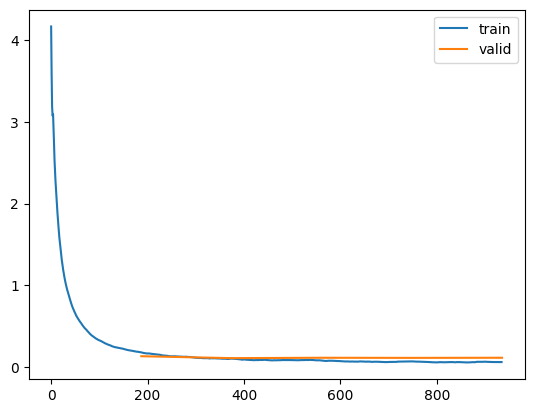

In [75]:
learn.recorder.plot_loss(skip_start=0)

Pay close attention to the training loss. See how the loss is getting really small while our validation loss is fluctuating, we might be slightly overfitting the data with this new optimizer!

In [76]:
# TODO 5
tst_logprobs, tst_targets = learn.get_preds(dl=test_dl)
# TODO 6
tst_loss, tst_acc = learn.validate(dl=test_dl) 
# TODO 7
tst_preds = tst_logprobs.argmax(axis=1)

print("Test loss: {:.5f} accuracy: {:.5f}".format(tst_loss, tst_acc))
tst_preds

TypeError: ignored

In [77]:
tst_incorrect_preds = torch.where((tst_targets == tst_preds) == False)[0]
print("Number of test data samples misclassified: {}".format(len(tst_incorrect_preds)))

TypeError: ignored

In [78]:
# TODO 8
tst_interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)

# We need this line or FastAI will throw an Assert error about dimensions not matching!
tst_interp.decoded = tst_interp.decoded.argmax(axis=1)

tst_interp.plot_confusion_matrix(title="Test Confusion Matrix")

IndexError: ignored

Take a second to compare the Adam results to the results we got when using SGD. You should be seeing that Adam performs slightly better but may also be slightly overfitting!

### Adding Special Layers: Dropout for Regularization 

Neural networks tend to overfit on datasets during training for various reasons. One way to prevent this is by using a regularization method like dropout. Dropout works by randomly turning off neurons in a layer with some probability. This turning off of neurons prevents the network from memorizing data and forces each neuron to play an active role in every input prediction. Note that dropout only applies during training not during validation or testing!

For more details on dropout see the below references.


- References
    - [A Gentle Introduction to Dropout for Regularizing Deep Neural Networks](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)
    - [What is Dropout? Reduce overfitting in your neural networks](https://www.machinecurve.com/index.php/2019/12/16/what-is-dropout-reduce-overfitting-in-your-neural-networks/)

<div id="TODO8"></div>

#### TODO 8
Now let's try incorporate dropout into our model to see if it helps!

**Warning: This may take a 5+ minutes to run and MUCH longer if you aren't using a GPU.**

1. Define an PyTorch neural network using the `nn.Sequential`.
    1. First add a `nn.Flatten` layer to our network to flatten the inputs.
    2. Next define the first linear `nn.Linear` hidden layer with 64 hidden units that is followed by a `nn.Dropout` with probability .25 and a `nn.ReLU` activation function. 
        1. Think about what the input size of the linear layer should be! We calculated it a while back! 
    3. Next define the second linear `nn.Linear` hidden layer with 64 hidden units that is followed by a `nn.Dropout` with probability .25 and a `nn.ReLU` activation function.
    4. Finally, define the output layer  `nn.Linear` where the number of hidden units is equal to the number of classes in our MNIST dataset. This output layer should be followed by a `nn.LogSoftmax` layer to turn our outputs into probabilities.
2. Declare the `NLLLoss` class and store the output into `nll_loss`.
3. Call `.fit()` method on `learn` which is an instance of `Learner`. Pass 5 epochs and a learning rate of .01 to the method as well. **Warning: This may take a few seconds and MUCH longer if you aren't using a GPU.**
4. Use the `.get_preds()` method for `learn` to get the test log probabilities and targets for our test data `test_dl`. Be sure to pass `test_dl` to the `dl` parameter! Store the outputs into `tst_logprobs` and `tst_targets`.
5. Use the `.validate` method for `learn` to get the test loss and accuracy.Be sure to pass `test_dl` to the `dl` parameter! Store the outputs into `tst_loss` and `tst_acc`.
6. Take the `argmax` of `tst_logprobs` to get the test predictions. Be sure to specify the correct axis! Store the output into `tst_preds`.
7. Create a `ClassificationInterpretation` instance by using the `.from_learner()` method. Be sure to pass our learner and test data `test_dl` to the method.

In [79]:
# TODO 1 
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=784),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(in_features = 784, out_features = hu),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(in_features=hu, out_features=hu),
    nn.LogSoftmax()
).to(device)


# TODO 2
nll_loss = nn.NLLLoss()

learn = Learner(trn_vld_dls, model, opt_func=Adam, loss_func=nll_loss, metrics=accuracy)

In [80]:
# TODO 3
learn.fit(5, lr = 0.01);

epoch,train_loss,valid_loss,accuracy,time
0,0.240263,0.157338,0.954917,00:50
1,0.182795,0.148028,0.955833,00:56
2,0.149019,0.115115,0.966500,00:52
3,0.137792,0.118460,0.967583,00:52
4,0.127959,0.124059,0.966750,00:54


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Notice that in the above output the loss never gets really small like we saw before when only using `Adam`. This is becuase of dropout! Even though our validation loss and accuracy might be slightly worse dropout prevents overfitting on the training data. We might be able to see this better if we ran more epochs.

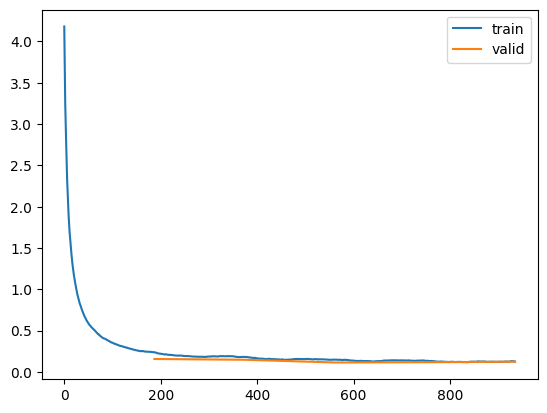

In [81]:
learn.recorder.plot_loss(skip_start=0)

In [83]:
# TODO 4
tst_logprobs, tst_targets = learn.get_preds(dl = test_dl)
# TODO 5
tst_loss, tst_acc = learn.validate(dl=test_dl)
# TODO 6
tst_preds = tst_logprobs.argmax(axis=1)

print("Test loss: {:.5f} accuracy: {:.5f}".format(tst_loss, tst_acc))
tst_preds

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


TypeError: ignored

In [84]:
tst_incorrect_preds = torch.where((tst_targets == tst_preds) == False)[0]
print("Number of test data samples misclassified: {}".format(len(tst_incorrect_preds)))

TypeError: ignored

In [85]:
# TODO 7
tst_interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)

# We need this line or FastAI will throw an Assert error about dimensions not matching!
tst_interp.decoded = tst_interp.decoded.argmax(axis=1)

tst_interp.plot_confusion_matrix(title="Test Confusion Matrix")

IndexError: ignored

### Testing Different Architectures

Now it's time to see if we can't improve our simple neural network by exploring different architectures. For now, we will limit the scope of "different architectures" to the number of hidden layers in a network and the number of hidden units in each layer.


<div id="TODO9"></div>

#### TODO 9
**Warning: This may take a while to run 10-15 minutes and MUCH longer if you aren't using a GPU.**

1. Define 3 different PyTorch `nn.Sequential` models. you can use any number of hidden units or layers as you want. Just be sure your model begins with a `nn.Flatten()` layer and ends with a `nn.LogSoftmax()` layer.
    1. Define your first model and store the output into `model1`.
    2. Define your second model and store the output into `model2`.
    3. Define your third model and store the output into `model3`.
2. Declare the `NLLLoss` class and store the output into `nll_loss`.
3. Create a `Learner` object just like we just did above but now pass FastAI's `Adam` optimizer to the `opt_func` parameter. Note that you can use `Adam` or `SGD` the choice is yours! 
4. Call `.fit()` method on `learn` which is an instance of `Learner`. Pass at least  and any learning rate you want (.1 for SGD and .01 for Adam are good starting points) to the method as well. 
5. Use the `.get_preds()` method for `learn` to get the test log probabilities and targets for our **validation**. Store the outputs into `vld_logprobs` and `vld_targets`.
6. Use the `.validate` method for `learn` to get the **validation** loss and accuracy. Store the outputs into `vld_loss` and `vld_acc`.
7. Take the `argmax` of `vld_logprobs` to get the validation predictions. Be sure to specify the correct axis! Store the output into `vld_preds`.
8. Create a `ClassificationInterpretation` instance by using the `.from_learner()` method and passing the current `learn` variable.

In [ ]:
# TODO 1-A
hu = 64;
model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=784),
    nn.ReLU(),
    nn.Linear(in_features = 784, out_features = hu),
    nn.ReLU(),
    nn.Linear(in_features=hu, out_features=hu),
    nn.LogSoftmax()).to(device)
#).to(device)

# TODO 1-B
model2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=784),
    nn.ReLU(),
    nn.Linear(in_features = 784, out_features = hu),
    nn.ReLU(),
    nn.Linear(in_features=hu, out_features=hu),
    nn.LogSoftmax()).to(device)
# TODO 1-C
model3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=784),
    nn.ReLU(),
    nn.Linear(in_features = 784, out_features = hu),
    nn.ReLU(),
    nn.Linear(in_features=hu, out_features=hu),
    nn.LogSoftmax()).to(device)

models = [model1, model2, model3]

# TODO 2
nll_loss = nn.NLLLoss()

learners = []
vld_losses = []
vld_accuracies = []
for i, model in enumerate(models):
    model_str = "Model-{}".format(i+1)
    print("{:=^50}".format(model_str))
    
    # TODO 3
    learn = Learner(trn_vld_dls, model, opt_func=Adam, loss_func=nll_loss, metrics=accuracy)
    # TODO 4
    learn.fit(5, lr = 0.01);
    # TODO 5
    vld_logprobs, vld_targets = learn.get_preds(dl = test_dl)
    # TODO 6
    vld_loss, vld_acc =  learn.validate(dl=test_dl)
    # TODO 7
    vld_preds = vld_logprobs.argmax(axis=1)
   
    vld_incorrect_preds = torch.where((vld_targets == vld_preds) == False)[0]
    print("Validation loss: {:.5f} accuracy: {:.5f}".format(vld_loss, vld_acc))
    print("Number of validation data samples misclassified: {}".format(len(vld_incorrect_preds)))
    
    # TODO 8
    vld_interp = tst_interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)

    # We need this line or FastAI will throw an Assert error about dimensions not matching!
    vld_interp.decoded = vld_interp.decoded.argmax(axis=1)

    vld_interp.plot_confusion_matrix(title="Test Confusion Matrix")
    plt.show()
    
    learners.append(learn)
    vld_losses.append(vld_loss)
    vld_accuracies.append(vld_acc)

=====================Model-1======================


epoch,train_loss,valid_loss,accuracy,time


<div id="TODO10"></div>

#### TODO 10

Now let's pick the best model from the above three models and try passing our testing data to it!

Let's first find the index of our best learner that we stored during the above training. To do so we need to take the `np.argmax` of either the `vld_accuracies` or `vld_losses`. They both should produce the same results so let's just use `vld_accuracies`
1. Take the `np.argmax()` of `vld_accuracies` to get the index of the learner which got the highest validation accuracy.
2. Use the `.get_preds()` method for `best_learner` to get the test log probabilities and targets for our **test data** `test_dl`. Be sure to pass `test_dl` to the `dl` parameter! Store the outputs into `tst_logprobs` and `tst_targets`.
3. Use the `.validate` method for `best_learner` to get the **test** loss and accuracy.Be sure to pass `test_dl` to the `dl` parameter! Store the outputs into `tst_loss` and `tst_acc`.
4. Take the `argmax` of `tst_logprobs` to get the **test** predictions. Be sure to specify the correct axis! Store the output into `tst_preds`.
5. Create a `ClassificationInterpretation` instance by using the `.from_learner()` method. Be sure to pass our learner and **test data** `test_dl` to the method.

In [89]:
# TODO 1
best_learner_idx = np.argmax(vld_accuracies)
best_learner = learners[best_learner_idx]
print("The learner and model with the highest accuracy was model {}".format(best_learner_idx+1))

ValueError: ignored

In [ ]:
# TODO 2
tst_logprobs, tst_targets = best_learner.get_preds(dl=test_dl)
# TODO 3
tst_loss, tst_acc = best_learner.validate(dl=test_dl)
# TODO 4
tst_preds =  tst_logprobs.argmax(axis=1)

print("Test loss: {:.5f} accuracy: {:.5f}".format(tst_loss, tst_acc))
tst_preds

In [ ]:
tst_incorrect_preds = torch.where((tst_targets == tst_preds) == False)[0]
print("Number of test data samples misclassified: {}".format(len(tst_incorrect_preds)))

In [ ]:
# TODO 5
tst_interp = ClassificationInterpretation.from_learner(best_learner, dl=test_dl)

# We need this line or FastAI will throw an Assert error about dimensions not matching!
tst_interp.decoded = tst_interp.decoded.argmax(axis=1)

tst_interp.plot_confusion_matrix(title="Test Confusion Matrix")

<div id="feedback"></div>

# Feedback TODO (2 point)

Did you enjoy the lab? 

Please take time to answer the following feedback qustions to help us further improve these labs! Your feedback is crucial to making these labs more useful!
    

* How do you rate the overall experience in this lab? (5 likert scale. i.e., 1 - poor ... 5 - amazing)  
Why do you think so? What was most/least useful?

`ANSWER`

* What did you find difficult about the lab? Were there any TODOs that were unclear? If so, what specfically did not make sense about it?


`ANSWER`

* Which concepts, if any, within the lab do you feel could use more explanation?

`ANSWER`